In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=80, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=80, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'

'''trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth is the one that works fine'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'

'''this would be with the seeds samples (40 aas)'''
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_seeds_40aas_nov2023_1.pth'

#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug.pth'


print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=batches)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


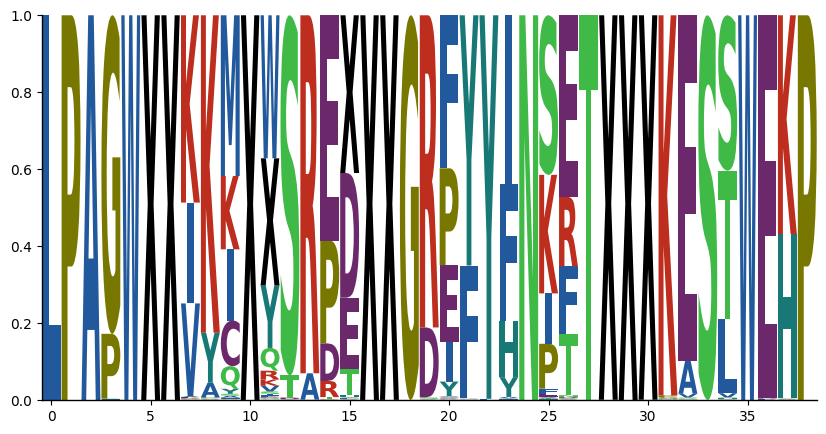

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq,1000, 1, logdir=logdir, out_modelname=outmodel_name )
    #check_parameter_historic = list(deepseq.parameters())
    #2500 iters before to make it converge in a good optima
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-9,12])#[-15,15] ) #[15,15]

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=1000, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # in iter 500 crash

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  10



Epoch 1/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)



Epoch 1/1000: 100%|██████████| 10/10 [00:01<00:00,  7.39samples/s]


Epoch 1/1000: 100%|██████████| 10/10 [00:01<00:00,  7.39samples/s, loss=1179.3837890625]


Epoch 1/1000: 100%|██████████| 10/10 [00:01<00:00,  6.68samples/s, loss=1179.3837890625]


Epoch 2/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 2/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]


Epoch 2/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=1191.7003173828125]


Epoch 2/1000: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=1191.7003173828125]


Epoch 3/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 3/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 3/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1179.803955078125]


Epoch 3/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=1179.803955078125]


Epoch 4/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 4/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 4/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1146.6990966796875]


Epoch 4/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=1146.6990966796875]


Epoch 5/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 5/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 5/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1126.1204833984375]


Epoch 5/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=1126.1204833984375]


Epoch 6/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 6/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 6/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=1123.6329345703125]


Epoch 6/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=1123.6329345703125]


Epoch 7/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 7/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]


Epoch 7/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=1127.0943603515625]


Epoch 7/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1127.0943603515625]


Epoch 8/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 8/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]


Epoch 8/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=1121.6055908203125]


Epoch 8/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1121.6055908203125]


Epoch 9/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 9/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 9/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1130.8101806640625]


Epoch 9/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1130.8101806640625]


Epoch 10/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 10/1000: 100%|██████████| 10/10 [00:01<00:00,  8.57samples/s]


Epoch 10/1000: 100%|██████████| 10/10 [00:01<00:00,  8.57samples/s, loss=1130.5904541015625]


Epoch 10/1000: 100%|██████████| 10/10 [00:01<00:00,  7.86samples/s, loss=1130.5904541015625]


Epoch 11/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 11/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 11/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=1129.86181640625]


Epoch 11/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=1129.86181640625]


Epoch 12/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 12/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 12/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1139.7440185546875]


Epoch 12/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=1139.7440185546875]


Epoch 13/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 13/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 13/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1126.8929443359375]


Epoch 13/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1126.8929443359375]


Epoch 14/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 14/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 14/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=1156.3614501953125]


Epoch 14/1000: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=1156.3614501953125]


Epoch 15/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 15/1000: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s]


Epoch 15/1000: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s, loss=1148.7578125]


Epoch 15/1000: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=1148.7578125]


Epoch 16/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 16/1000: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s]


Epoch 16/1000: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s, loss=1131.615478515625]


Epoch 16/1000: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=1131.615478515625]


Epoch 17/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 17/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]


Epoch 17/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=1131.2320556640625]


Epoch 17/1000: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=1131.2320556640625]


Epoch 18/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 18/1000: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]


Epoch 18/1000: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1126.56982421875]


Epoch 18/1000: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=1126.56982421875]


Epoch 19/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 19/1000: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]


Epoch 19/1000: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=1121.1744384765625]


Epoch 19/1000: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1121.1744384765625]


Epoch 20/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 20/1000: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]


Epoch 20/1000: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=1124.000732421875]


Epoch 20/1000: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=1124.000732421875]


Epoch 21/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 21/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 21/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1125.15185546875]


Epoch 21/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1125.15185546875]


Epoch 22/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 22/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 22/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1135.1314697265625]


Epoch 22/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=1135.1314697265625]


Epoch 23/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 23/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 23/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=1143.635009765625]


Epoch 23/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1143.635009765625]


Epoch 24/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 24/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 24/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=1144.662841796875]


Epoch 24/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1144.662841796875]


Epoch 25/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 25/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 25/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=1138.782470703125]


Epoch 25/1000: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=1138.782470703125]


Epoch 26/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 26/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 26/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1141.0384521484375]


Epoch 26/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1141.0384521484375]


Epoch 27/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 27/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 27/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=1145.8677978515625]


Epoch 27/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1145.8677978515625]


Epoch 28/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 28/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 28/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1145.7908935546875]


Epoch 28/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1145.7908935546875]


Epoch 29/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 29/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 29/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=1142.71728515625]


Epoch 29/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=1142.71728515625]


Epoch 30/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 30/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 30/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1147.6229248046875]


Epoch 30/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=1147.6229248046875]


Epoch 31/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 31/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 31/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1142.82958984375]


Epoch 31/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1142.82958984375]


Epoch 32/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 32/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 32/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1140.3590087890625]


Epoch 32/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1140.3590087890625]


Epoch 33/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 33/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 33/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1146.3851318359375]


Epoch 33/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=1146.3851318359375]


Epoch 34/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 34/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 34/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1143.5574951171875]


Epoch 34/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1143.5574951171875]


Epoch 35/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 35/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 35/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=1134.6871337890625]


Epoch 35/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=1134.6871337890625]


Epoch 36/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 36/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 36/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=1142.363037109375]


Epoch 36/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1142.363037109375]


Epoch 37/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 37/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 37/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1141.122314453125]


Epoch 37/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=1141.122314453125]


Epoch 38/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 38/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 38/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1137.3323974609375]


Epoch 38/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1137.3323974609375]


Epoch 39/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 39/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 39/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1136.51953125]


Epoch 39/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1136.51953125]


Epoch 40/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 40/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 40/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1136.501953125]


Epoch 40/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=1136.501953125]


Epoch 41/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 41/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 41/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=1115.7008056640625]


Epoch 41/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1115.7008056640625]


Epoch 42/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 42/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 42/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1121.287353515625]


Epoch 42/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1121.287353515625]


Epoch 43/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 43/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 43/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1112.5789794921875]


Epoch 43/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=1112.5789794921875]


Epoch 44/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 44/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 44/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1111.1934814453125]


Epoch 44/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1111.1934814453125]


Epoch 45/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 45/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 45/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1127.5035400390625]


Epoch 45/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1127.5035400390625]


Epoch 46/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 46/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 46/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1101.0814208984375]


Epoch 46/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1101.0814208984375]


Epoch 47/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 47/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 47/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1113.986083984375]


Epoch 47/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1113.986083984375]


Epoch 48/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 48/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 48/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1133.0819091796875]


Epoch 48/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=1133.0819091796875]


Epoch 49/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 49/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 49/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1100.46484375]


Epoch 49/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=1100.46484375]


Epoch 50/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 50/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 50/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=1125.3973388671875]


Epoch 50/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1125.3973388671875]


Epoch 51/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 51/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 51/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=1136.231689453125]


Epoch 51/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1136.231689453125]


Epoch 52/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 52/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 52/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=1131.0052490234375]


Epoch 52/1000: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=1131.0052490234375]


Epoch 53/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 53/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 53/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1117.0291748046875]


Epoch 53/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1117.0291748046875]


Epoch 54/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 54/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 54/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=1126.862060546875]


Epoch 54/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1126.862060546875]


Epoch 55/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 55/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 55/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1132.6129150390625]


Epoch 55/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=1132.6129150390625]


Epoch 56/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 56/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 56/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=1131.103271484375]


Epoch 56/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=1131.103271484375]


Epoch 57/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 57/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 57/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1121.266357421875]


Epoch 57/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=1121.266357421875]


Epoch 58/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 58/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 58/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=1136.5780029296875]


Epoch 58/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=1136.5780029296875]


Epoch 59/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 59/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 59/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=1122.3406982421875]


Epoch 59/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1122.3406982421875]


Epoch 60/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 60/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 60/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1121.4344482421875]


Epoch 60/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=1121.4344482421875]


Epoch 61/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 61/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 61/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1123.7412109375]


Epoch 61/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1123.7412109375]


Epoch 62/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 62/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 62/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=1124.6593017578125]


Epoch 62/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1124.6593017578125]


Epoch 63/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 63/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 63/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1127.9195556640625]


Epoch 63/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=1127.9195556640625]


Epoch 64/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 64/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 64/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1118.6614990234375]


Epoch 64/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1118.6614990234375]


Epoch 65/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 65/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 65/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=1112.318359375]


Epoch 65/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=1112.318359375]


Epoch 66/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 66/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 66/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1107.36083984375]


Epoch 66/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=1107.36083984375]


Epoch 67/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 67/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 67/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1112.15234375]


Epoch 67/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1112.15234375]


Epoch 68/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 68/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 68/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=1127.654052734375]


Epoch 68/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1127.654052734375]


Epoch 69/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 69/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 69/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=1125.1251220703125]


Epoch 69/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1125.1251220703125]


Epoch 70/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 70/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 70/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=1122.50732421875]


Epoch 70/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=1122.50732421875]


Epoch 71/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 71/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]


Epoch 71/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=1111.3707275390625]


Epoch 71/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1111.3707275390625]


Epoch 72/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 72/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 72/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=1110.6204833984375]


Epoch 72/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=1110.6204833984375]


Epoch 73/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 73/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 73/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1124.6322021484375]


Epoch 73/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1124.6322021484375]


Epoch 74/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 74/1000: 100%|██████████| 10/10 [00:00<00:00, 11.90samples/s]


Epoch 74/1000: 100%|██████████| 10/10 [00:00<00:00, 11.90samples/s, loss=1112.68798828125]


Epoch 74/1000: 100%|██████████| 10/10 [00:00<00:00, 10.66samples/s, loss=1112.68798828125]


Epoch 75/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 75/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s]


Epoch 75/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s, loss=1120.66845703125]


Epoch 75/1000: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=1120.66845703125]


Epoch 76/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 76/1000: 100%|██████████| 10/10 [00:00<00:00, 12.00samples/s]


Epoch 76/1000: 100%|██████████| 10/10 [00:00<00:00, 12.00samples/s, loss=1111.4530029296875]


Epoch 76/1000: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=1111.4530029296875]


Epoch 77/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 77/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 77/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1119.782958984375]


Epoch 77/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=1119.782958984375]


Epoch 78/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 78/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 78/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1118.341064453125]


Epoch 78/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=1118.341064453125]


Epoch 79/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 79/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 79/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=1115.010986328125]


Epoch 79/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=1115.010986328125]


Epoch 80/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 80/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 80/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=1119.1019287109375]


Epoch 80/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=1119.1019287109375]


Epoch 81/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 81/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 81/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=1110.967529296875]


Epoch 81/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1110.967529296875]


Epoch 82/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 82/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 82/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1115.97998046875]


Epoch 82/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=1115.97998046875]


Epoch 83/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 83/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 83/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=1101.40966796875]


Epoch 83/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=1101.40966796875]


Epoch 84/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 84/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 84/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1112.298095703125]


Epoch 84/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1112.298095703125]


Epoch 85/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 85/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 85/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1119.656494140625]


Epoch 85/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=1119.656494140625]


Epoch 86/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 86/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 86/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1119.4884033203125]


Epoch 86/1000: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=1119.4884033203125]


Epoch 87/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 87/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 87/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1123.40283203125]


Epoch 87/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1123.40283203125]


Epoch 88/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 88/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 88/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=1115.625]


Epoch 88/1000: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=1115.625]


Epoch 89/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 89/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 89/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1120.7037353515625]


Epoch 89/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1120.7037353515625]


Epoch 90/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 90/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 90/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1109.640625]


Epoch 90/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=1109.640625]


Epoch 91/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 91/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 91/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1090.4951171875]


Epoch 91/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1090.4951171875]


Epoch 92/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 92/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 92/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1101.1390380859375]


Epoch 92/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1101.1390380859375]


Epoch 93/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 93/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 93/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=1104.107666015625]


Epoch 93/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=1104.107666015625]


Epoch 94/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 94/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 94/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1135.2730712890625]


Epoch 94/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=1135.2730712890625]


Epoch 95/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 95/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 95/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=1115.5693359375]


Epoch 95/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=1115.5693359375]


Epoch 96/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 96/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 96/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=1095.967529296875]


Epoch 96/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=1095.967529296875]


Epoch 97/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 97/1000: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s]


Epoch 97/1000: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s, loss=1118.6676025390625]


Epoch 97/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=1118.6676025390625]


Epoch 98/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 98/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 98/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=1113.523193359375]


Epoch 98/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=1113.523193359375]


Epoch 99/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 99/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 99/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1102.08740234375]


Epoch 99/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=1102.08740234375]


Epoch 100/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 100/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 100/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1102.510986328125]


Epoch 100/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=1102.510986328125]


Epoch 101/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 101/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 101/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1108.360107421875]


Epoch 101/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1108.360107421875]


Epoch 102/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 102/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 102/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1107.9144287109375]


Epoch 102/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1107.9144287109375]


Epoch 103/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 103/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 103/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=1107.60107421875]


Epoch 103/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=1107.60107421875]


Epoch 104/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 104/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 104/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=1103.4122314453125]


Epoch 104/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=1103.4122314453125]


Epoch 105/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 105/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 105/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=1096.4219970703125]


Epoch 105/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1096.4219970703125]


Epoch 106/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 106/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 106/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1102.73046875]


Epoch 106/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=1102.73046875]


Epoch 107/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 107/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 107/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1092.34228515625]


Epoch 107/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=1092.34228515625]


Epoch 108/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 108/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]


Epoch 108/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=1111.1630859375]


Epoch 108/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=1111.1630859375]


Epoch 109/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 109/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 109/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=1110.1524658203125]


Epoch 109/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=1110.1524658203125]


Epoch 110/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 110/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 110/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=1100.76806640625]


Epoch 110/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=1100.76806640625]


Epoch 111/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 111/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 111/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=1107.6077880859375]


Epoch 111/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=1107.6077880859375]


Epoch 112/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 112/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 112/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=1100.417724609375]


Epoch 112/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=1100.417724609375]


Epoch 113/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 113/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 113/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1118.7916259765625]


Epoch 113/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1118.7916259765625]


Epoch 114/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 114/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 114/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1122.0882568359375]


Epoch 114/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=1122.0882568359375]


Epoch 115/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 115/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 115/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1106.73291015625]


Epoch 115/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=1106.73291015625]


Epoch 116/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 116/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 116/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1108.1627197265625]


Epoch 116/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1108.1627197265625]


Epoch 117/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 117/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 117/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1112.6722412109375]


Epoch 117/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=1112.6722412109375]


Epoch 118/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 118/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 118/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1113.212646484375]


Epoch 118/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1113.212646484375]


Epoch 119/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 119/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 119/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1098.4456787109375]


Epoch 119/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1098.4456787109375]


Epoch 120/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 120/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 120/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1104.4935302734375]


Epoch 120/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1104.4935302734375]


Epoch 121/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 121/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 121/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1110.9686279296875]


Epoch 121/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=1110.9686279296875]


Epoch 122/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 122/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 122/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=1094.578857421875]


Epoch 122/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=1094.578857421875]


Epoch 123/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 123/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 123/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=1080.59716796875]


Epoch 123/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=1080.59716796875]


Epoch 124/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 124/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 124/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1104.5972900390625]


Epoch 124/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1104.5972900390625]


Epoch 125/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 125/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 125/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1093.3055419921875]


Epoch 125/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1093.3055419921875]


Epoch 126/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 126/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 126/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1102.868896484375]


Epoch 126/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1102.868896484375]


Epoch 127/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 127/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 127/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1088.38427734375]


Epoch 127/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1088.38427734375]


Epoch 128/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 128/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 128/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1109.9783935546875]


Epoch 128/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1109.9783935546875]


Epoch 129/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 129/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 129/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1101.3592529296875]


Epoch 129/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1101.3592529296875]


Epoch 130/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 130/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 130/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1080.4329833984375]


Epoch 130/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1080.4329833984375]


Epoch 131/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 131/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 131/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1089.269287109375]


Epoch 131/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1089.269287109375]


Epoch 132/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 132/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 132/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1084.5673828125]


Epoch 132/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=1084.5673828125]


Epoch 133/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 133/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 133/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1089.0498046875]


Epoch 133/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=1089.0498046875]


Epoch 134/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 134/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 134/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1081.2769775390625]


Epoch 134/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1081.2769775390625]


Epoch 135/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 135/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 135/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1105.7115478515625]


Epoch 135/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1105.7115478515625]


Epoch 136/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 136/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 136/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=1084.3765869140625]


Epoch 136/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1084.3765869140625]


Epoch 137/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 137/1000: 100%|██████████| 10/10 [00:00<00:00, 11.04samples/s]


Epoch 137/1000: 100%|██████████| 10/10 [00:00<00:00, 11.04samples/s, loss=1092.722412109375]


Epoch 137/1000: 100%|██████████| 10/10 [00:01<00:00,  9.86samples/s, loss=1092.722412109375]


Epoch 138/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 138/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 138/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1080.5687255859375]


Epoch 138/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1080.5687255859375]


Epoch 139/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 139/1000: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s]


Epoch 139/1000: 100%|██████████| 10/10 [00:00<00:00, 11.40samples/s, loss=1083.3681640625]


Epoch 139/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=1083.3681640625]


Epoch 140/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 140/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 140/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=1083.9219970703125]


Epoch 140/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=1083.9219970703125]


Epoch 141/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 141/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 141/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=1070.9134521484375]


Epoch 141/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1070.9134521484375]


Epoch 142/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 142/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 142/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1077.6070556640625]


Epoch 142/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1077.6070556640625]


Epoch 143/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 143/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 143/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1073.64453125]


Epoch 143/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1073.64453125]


Epoch 144/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 144/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 144/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1092.2364501953125]


Epoch 144/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=1092.2364501953125]


Epoch 145/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 145/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 145/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1076.07080078125]


Epoch 145/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1076.07080078125]


Epoch 146/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 146/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 146/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1089.4749755859375]


Epoch 146/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1089.4749755859375]


Epoch 147/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 147/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 147/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=1073.6390380859375]


Epoch 147/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1073.6390380859375]


Epoch 148/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 148/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 148/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1091.4716796875]


Epoch 148/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1091.4716796875]


Epoch 149/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 149/1000: 100%|██████████| 10/10 [00:01<00:00,  9.73samples/s]


Epoch 149/1000: 100%|██████████| 10/10 [00:01<00:00,  9.73samples/s, loss=1079.211181640625]


Epoch 149/1000: 100%|██████████| 10/10 [00:01<00:00,  8.79samples/s, loss=1079.211181640625]


Epoch 150/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 150/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 150/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=1073.8294677734375]


Epoch 150/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=1073.8294677734375]


Epoch 151/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 151/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 151/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1089.3082275390625]


Epoch 151/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1089.3082275390625]


Epoch 152/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 152/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 152/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1073.702880859375]


Epoch 152/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1073.702880859375]


Epoch 153/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 153/1000: 100%|██████████| 10/10 [00:00<00:00, 12.00samples/s]


Epoch 153/1000: 100%|██████████| 10/10 [00:00<00:00, 12.00samples/s, loss=1076.9969482421875]


Epoch 153/1000: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=1076.9969482421875]


Epoch 154/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 154/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 154/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1066.3175048828125]


Epoch 154/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=1066.3175048828125]


Epoch 155/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 155/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 155/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=1103.3482666015625]


Epoch 155/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1103.3482666015625]


Epoch 156/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 156/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 156/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1073.751953125]


Epoch 156/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1073.751953125]


Epoch 157/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 157/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 157/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1069.0567626953125]


Epoch 157/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1069.0567626953125]


Epoch 158/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 158/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 158/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1073.87353515625]


Epoch 158/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1073.87353515625]


Epoch 159/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 159/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 159/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1063.4481201171875]


Epoch 159/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1063.4481201171875]


Epoch 160/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 160/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 160/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1073.904541015625]


Epoch 160/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1073.904541015625]


Epoch 161/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 161/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 161/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=1070.36181640625]


Epoch 161/1000: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=1070.36181640625]


Epoch 162/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 162/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 162/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=1073.7286376953125]


Epoch 162/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=1073.7286376953125]


Epoch 163/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 163/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 163/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1053.1552734375]


Epoch 163/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1053.1552734375]


Epoch 164/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 164/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 164/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=1053.55029296875]


Epoch 164/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1053.55029296875]


Epoch 165/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 165/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 165/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=1074.7640380859375]


Epoch 165/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1074.7640380859375]


Epoch 166/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 166/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]


Epoch 166/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=1071.9359130859375]


Epoch 166/1000: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=1071.9359130859375]


Epoch 167/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 167/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 167/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=1059.370849609375]


Epoch 167/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1059.370849609375]


Epoch 168/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 168/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]


Epoch 168/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=1072.5467529296875]


Epoch 168/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=1072.5467529296875]


Epoch 169/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 169/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 169/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1066.0491943359375]


Epoch 169/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1066.0491943359375]


Epoch 170/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 170/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 170/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1082.087158203125]


Epoch 170/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1082.087158203125]


Epoch 171/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 171/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 171/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1077.7861328125]


Epoch 171/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1077.7861328125]


Epoch 172/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 172/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 172/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1081.31884765625]


Epoch 172/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1081.31884765625]


Epoch 173/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 173/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 173/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=1060.3858642578125]


Epoch 173/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=1060.3858642578125]


Epoch 174/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 174/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 174/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=1078.352294921875]


Epoch 174/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1078.352294921875]


Epoch 175/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 175/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 175/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1080.96484375]


Epoch 175/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1080.96484375]


Epoch 176/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 176/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 176/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1084.606201171875]


Epoch 176/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1084.606201171875]


Epoch 177/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 177/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]


Epoch 177/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=1063.1849365234375]


Epoch 177/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=1063.1849365234375]


Epoch 178/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 178/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 178/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1069.34814453125]


Epoch 178/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1069.34814453125]


Epoch 179/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 179/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 179/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=1062.4573974609375]


Epoch 179/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1062.4573974609375]


Epoch 180/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 180/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 180/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1055.2667236328125]


Epoch 180/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1055.2667236328125]


Epoch 181/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 181/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 181/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=1080.624267578125]


Epoch 181/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1080.624267578125]


Epoch 182/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 182/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 182/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1060.01806640625]


Epoch 182/1000: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=1060.01806640625]


Epoch 183/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 183/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 183/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1073.02197265625]


Epoch 183/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1073.02197265625]


Epoch 184/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 184/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 184/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=1075.650146484375]


Epoch 184/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=1075.650146484375]


Epoch 185/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 185/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 185/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=1062.888916015625]


Epoch 185/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=1062.888916015625]


Epoch 186/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 186/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 186/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1063.559814453125]


Epoch 186/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=1063.559814453125]


Epoch 187/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 187/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]


Epoch 187/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=1073.1171875]


Epoch 187/1000: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=1073.1171875]


Epoch 188/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 188/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 188/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1059.506591796875]


Epoch 188/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1059.506591796875]


Epoch 189/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 189/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 189/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=1061.537841796875]


Epoch 189/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=1061.537841796875]


Epoch 190/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 190/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 190/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=1056.3055419921875]


Epoch 190/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1056.3055419921875]


Epoch 191/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 191/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 191/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=1069.175537109375]


Epoch 191/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=1069.175537109375]


Epoch 192/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 192/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 192/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1061.586669921875]


Epoch 192/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=1061.586669921875]


Epoch 193/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 193/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 193/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=1071.323486328125]


Epoch 193/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=1071.323486328125]


Epoch 194/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 194/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 194/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1053.2027587890625]


Epoch 194/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=1053.2027587890625]


Epoch 195/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 195/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 195/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=1050.7701416015625]


Epoch 195/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=1050.7701416015625]


Epoch 196/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 196/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 196/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=1056.36474609375]


Epoch 196/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1056.36474609375]


Epoch 197/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 197/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 197/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1055.9534912109375]


Epoch 197/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=1055.9534912109375]


Epoch 198/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 198/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 198/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1064.10498046875]


Epoch 198/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=1064.10498046875]


Epoch 199/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 199/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 199/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1063.3702392578125]


Epoch 199/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1063.3702392578125]


Epoch 200/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 200/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 200/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1064.94091796875]


Epoch 200/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1064.94091796875]


Epoch 201/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 201/1000: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s]


Epoch 201/1000: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s, loss=1075.16162109375]


Epoch 201/1000: 100%|██████████| 10/10 [00:01<00:00,  9.03samples/s, loss=1075.16162109375]


Epoch 202/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 202/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]


Epoch 202/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=1055.515869140625]


Epoch 202/1000: 100%|██████████| 10/10 [00:01<00:00,  9.52samples/s, loss=1055.515869140625]


Epoch 203/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 203/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]


Epoch 203/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=1061.51708984375]


Epoch 203/1000: 100%|██████████| 10/10 [00:01<00:00,  9.45samples/s, loss=1061.51708984375]


Epoch 204/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 204/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 204/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1066.2542724609375]


Epoch 204/1000: 100%|██████████| 10/10 [00:01<00:00,  9.84samples/s, loss=1066.2542724609375]


Epoch 205/1000:   0%|          | 0/10 [00:00<?, ?samples/s]

From Here



Epoch 205/1000: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]


Epoch 205/1000: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=1056.1175537109375]


Epoch 205/1000: 100%|██████████| 10/10 [00:01<00:00,  9.60samples/s, loss=1056.1175537109375]


Epoch 206/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 206/1000: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s]


Epoch 206/1000: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=1059.6944580078125]


Epoch 206/1000: 100%|██████████| 10/10 [00:01<00:00,  8.89samples/s, loss=1059.6944580078125]


Epoch 207/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 207/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 207/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=1069.3914794921875]


Epoch 207/1000: 100%|██████████| 10/10 [00:01<00:00,  9.82samples/s, loss=1069.3914794921875]


Epoch 208/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 208/1000: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]


Epoch 208/1000: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1037.277099609375]


Epoch 208/1000: 100%|██████████| 10/10 [00:01<00:00,  9.22samples/s, loss=1037.277099609375]


Epoch 209/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 209/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s]


Epoch 209/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=1071.673828125]


Epoch 209/1000: 100%|██████████| 10/10 [00:01<00:00,  8.56samples/s, loss=1071.673828125]


Epoch 210/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 210/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 210/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=1061.5631103515625]


Epoch 210/1000: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1061.5631103515625]


Epoch 211/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 211/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 211/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=1091.770751953125]


Epoch 211/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=1091.770751953125]


Epoch 212/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 212/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 212/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1063.8162841796875]


Epoch 212/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1063.8162841796875]


Epoch 213/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 213/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 213/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=1075.96435546875]


Epoch 213/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=1075.96435546875]


Epoch 214/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 214/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 214/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=1077.4005126953125]


Epoch 214/1000: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=1077.4005126953125]


Epoch 215/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 215/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 215/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1088.104248046875]


Epoch 215/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=1088.104248046875]


Epoch 216/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 216/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 216/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1069.3665771484375]


Epoch 216/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1069.3665771484375]


Epoch 217/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 217/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 217/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1049.9744873046875]


Epoch 217/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1049.9744873046875]


Epoch 218/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 218/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 218/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1072.4779052734375]


Epoch 218/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1072.4779052734375]


Epoch 219/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 219/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 219/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1055.6219482421875]


Epoch 219/1000: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=1055.6219482421875]


Epoch 220/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 220/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 220/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1075.4990234375]


Epoch 220/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1075.4990234375]


Epoch 221/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 221/1000: 100%|██████████| 10/10 [00:00<00:00, 12.28samples/s]


Epoch 221/1000: 100%|██████████| 10/10 [00:00<00:00, 12.28samples/s, loss=1063.4537353515625]


Epoch 221/1000: 100%|██████████| 10/10 [00:00<00:00, 10.92samples/s, loss=1063.4537353515625]


Epoch 222/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 222/1000: 100%|██████████| 10/10 [00:00<00:00, 11.95samples/s]


Epoch 222/1000: 100%|██████████| 10/10 [00:00<00:00, 11.95samples/s, loss=1073.6610107421875]


Epoch 222/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=1073.6610107421875]


Epoch 223/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 223/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 223/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1086.2427978515625]


Epoch 223/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=1086.2427978515625]


Epoch 224/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 224/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 224/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1099.494384765625]


Epoch 224/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1099.494384765625]


Epoch 225/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 225/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 225/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1104.6221923828125]


Epoch 225/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1104.6221923828125]


Epoch 226/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 226/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 226/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=1081.4801025390625]


Epoch 226/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1081.4801025390625]


Epoch 227/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 227/1000: 100%|██████████| 10/10 [00:00<00:00, 12.00samples/s]


Epoch 227/1000: 100%|██████████| 10/10 [00:00<00:00, 12.00samples/s, loss=1045.553955078125]


Epoch 227/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=1045.553955078125]


Epoch 228/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 228/1000: 100%|██████████| 10/10 [00:00<00:00, 11.90samples/s]


Epoch 228/1000: 100%|██████████| 10/10 [00:00<00:00, 11.90samples/s, loss=1072.5360107421875]


Epoch 228/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=1072.5360107421875]


Epoch 229/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 229/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 229/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1077.5238037109375]


Epoch 229/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1077.5238037109375]


Epoch 230/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 230/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 230/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1066.03564453125]


Epoch 230/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1066.03564453125]


Epoch 231/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 231/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 231/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1059.1490478515625]


Epoch 231/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=1059.1490478515625]


Epoch 232/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 232/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 232/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1056.8828125]


Epoch 232/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1056.8828125]


Epoch 233/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 233/1000: 100%|██████████| 10/10 [00:00<00:00, 11.93samples/s]


Epoch 233/1000: 100%|██████████| 10/10 [00:00<00:00, 11.93samples/s, loss=1090.794189453125]


Epoch 233/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=1090.794189453125]


Epoch 234/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 234/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 234/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=1115.0076904296875]


Epoch 234/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1115.0076904296875]


Epoch 235/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 235/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 235/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=1072.2713623046875]


Epoch 235/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1072.2713623046875]


Epoch 236/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 236/1000: 100%|██████████| 10/10 [00:00<00:00, 12.27samples/s]


Epoch 236/1000: 100%|██████████| 10/10 [00:00<00:00, 12.27samples/s, loss=1075.1663818359375]


Epoch 236/1000: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=1075.1663818359375]


Epoch 237/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 237/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s]


Epoch 237/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s, loss=1075.2855224609375]


Epoch 237/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=1075.2855224609375]


Epoch 238/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 238/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 238/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=1079.0211181640625]


Epoch 238/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=1079.0211181640625]


Epoch 239/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 239/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 239/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=1061.9696044921875]


Epoch 239/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1061.9696044921875]


Epoch 240/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 240/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 240/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=1068.0252685546875]


Epoch 240/1000: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1068.0252685546875]


Epoch 241/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 241/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 241/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=1055.80029296875]


Epoch 241/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1055.80029296875]


Epoch 242/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 242/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 242/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1074.1239013671875]


Epoch 242/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=1074.1239013671875]


Epoch 243/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 243/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 243/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1061.0665283203125]


Epoch 243/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1061.0665283203125]


Epoch 244/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 244/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 244/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=1072.2528076171875]


Epoch 244/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=1072.2528076171875]


Epoch 245/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 245/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 245/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=1070.478759765625]


Epoch 245/1000: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1070.478759765625]


Epoch 246/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 246/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 246/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=1043.646728515625]


Epoch 246/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=1043.646728515625]


Epoch 247/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 247/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 247/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1057.194091796875]


Epoch 247/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=1057.194091796875]


Epoch 248/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 248/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 248/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1050.0096435546875]


Epoch 248/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1050.0096435546875]


Epoch 249/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 249/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 249/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=1056.634765625]


Epoch 249/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1056.634765625]


Epoch 250/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 250/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 250/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1033.4296875]


Epoch 250/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=1033.4296875]


Epoch 251/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 251/1000: 100%|██████████| 10/10 [00:00<00:00, 12.09samples/s]


Epoch 251/1000: 100%|██████████| 10/10 [00:00<00:00, 12.09samples/s, loss=1052.5701904296875]


Epoch 251/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1052.5701904296875]


Epoch 252/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 252/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 252/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1068.8304443359375]


Epoch 252/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=1068.8304443359375]


Epoch 253/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 253/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 253/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=1052.7144775390625]


Epoch 253/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=1052.7144775390625]


Epoch 254/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 254/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 254/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1048.749755859375]


Epoch 254/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1048.749755859375]


Epoch 255/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 255/1000: 100%|██████████| 10/10 [00:00<00:00, 11.94samples/s]


Epoch 255/1000: 100%|██████████| 10/10 [00:00<00:00, 11.94samples/s, loss=1060.01025390625]


Epoch 255/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=1060.01025390625]


Epoch 256/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 256/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 256/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1030.9954833984375]


Epoch 256/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=1030.9954833984375]


Epoch 257/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 257/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 257/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1039.2261962890625]


Epoch 257/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1039.2261962890625]


Epoch 258/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 258/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 258/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1049.528076171875]


Epoch 258/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1049.528076171875]


Epoch 259/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 259/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 259/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1054.6279296875]


Epoch 259/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1054.6279296875]


Epoch 260/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 260/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 260/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=1056.3363037109375]


Epoch 260/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1056.3363037109375]


Epoch 261/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 261/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 261/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=1072.3758544921875]


Epoch 261/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=1072.3758544921875]


Epoch 262/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 262/1000: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]


Epoch 262/1000: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=1042.2061767578125]


Epoch 262/1000: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1042.2061767578125]


Epoch 263/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 263/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 263/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=1061.7108154296875]


Epoch 263/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1061.7108154296875]


Epoch 264/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 264/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 264/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1084.0255126953125]


Epoch 264/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=1084.0255126953125]


Epoch 265/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 265/1000: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s]


Epoch 265/1000: 100%|██████████| 10/10 [00:00<00:00, 11.39samples/s, loss=1076.420166015625]


Epoch 265/1000: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=1076.420166015625]


Epoch 266/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 266/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 266/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=1049.21533203125]


Epoch 266/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=1049.21533203125]


Epoch 267/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 267/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 267/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1065.4769287109375]


Epoch 267/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1065.4769287109375]


Epoch 268/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 268/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 268/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=1048.9737548828125]


Epoch 268/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=1048.9737548828125]


Epoch 269/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 269/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 269/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1026.4873046875]


Epoch 269/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1026.4873046875]


Epoch 270/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 270/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 270/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1044.2578125]


Epoch 270/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1044.2578125]


Epoch 271/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 271/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]


Epoch 271/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=1062.607666015625]


Epoch 271/1000: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1062.607666015625]


Epoch 272/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 272/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 272/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1091.35009765625]


Epoch 272/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1091.35009765625]


Epoch 273/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 273/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 273/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=1065.085205078125]


Epoch 273/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=1065.085205078125]


Epoch 274/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 274/1000: 100%|██████████| 10/10 [00:00<00:00, 12.06samples/s]


Epoch 274/1000: 100%|██████████| 10/10 [00:00<00:00, 12.06samples/s, loss=1036.59228515625]


Epoch 274/1000: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=1036.59228515625]


Epoch 275/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 275/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 275/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=1054.7821044921875]


Epoch 275/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1054.7821044921875]


Epoch 276/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 276/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 276/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=1059.82080078125]


Epoch 276/1000: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=1059.82080078125]


Epoch 277/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 277/1000: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]


Epoch 277/1000: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=1066.59619140625]


Epoch 277/1000: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=1066.59619140625]


Epoch 278/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 278/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 278/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1030.2374267578125]


Epoch 278/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=1030.2374267578125]


Epoch 279/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 279/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 279/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=1041.221923828125]


Epoch 279/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1041.221923828125]


Epoch 280/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 280/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 280/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1053.3682861328125]


Epoch 280/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1053.3682861328125]


Epoch 281/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 281/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 281/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1035.725830078125]


Epoch 281/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1035.725830078125]


Epoch 282/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 282/1000: 100%|██████████| 10/10 [00:00<00:00, 12.11samples/s]


Epoch 282/1000: 100%|██████████| 10/10 [00:00<00:00, 12.11samples/s, loss=1037.9366455078125]


Epoch 282/1000: 100%|██████████| 10/10 [00:00<00:00, 10.68samples/s, loss=1037.9366455078125]


Epoch 283/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 283/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 283/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1035.7762451171875]


Epoch 283/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1035.7762451171875]


Epoch 284/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 284/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 284/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1044.1453857421875]


Epoch 284/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1044.1453857421875]


Epoch 285/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 285/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 285/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=1045.76416015625]


Epoch 285/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1045.76416015625]


Epoch 286/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 286/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 286/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=1030.1571044921875]


Epoch 286/1000: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=1030.1571044921875]


Epoch 287/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 287/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 287/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1047.8739013671875]


Epoch 287/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=1047.8739013671875]


Epoch 288/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 288/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 288/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1025.6343994140625]


Epoch 288/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=1025.6343994140625]


Epoch 289/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 289/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 289/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1047.8590087890625]


Epoch 289/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1047.8590087890625]


Epoch 290/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 290/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 290/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=1040.384521484375]


Epoch 290/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1040.384521484375]


Epoch 291/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 291/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 291/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1031.267822265625]


Epoch 291/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=1031.267822265625]


Epoch 292/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 292/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]


Epoch 292/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=1017.8480834960938]


Epoch 292/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=1017.8480834960938]


Epoch 293/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 293/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 293/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1047.45654296875]


Epoch 293/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=1047.45654296875]


Epoch 294/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 294/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 294/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1049.293212890625]


Epoch 294/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=1049.293212890625]


Epoch 295/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 295/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]


Epoch 295/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=1032.8121337890625]


Epoch 295/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=1032.8121337890625]


Epoch 296/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 296/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 296/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=1031.5548095703125]


Epoch 296/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=1031.5548095703125]


Epoch 297/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 297/1000: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s]


Epoch 297/1000: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s, loss=1039.7259521484375]


Epoch 297/1000: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=1039.7259521484375]


Epoch 298/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 298/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 298/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1025.3629150390625]


Epoch 298/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1025.3629150390625]


Epoch 299/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 299/1000: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]


Epoch 299/1000: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=1012.42626953125]


Epoch 299/1000: 100%|██████████| 10/10 [00:01<00:00,  9.84samples/s, loss=1012.42626953125]


Epoch 300/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 300/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 300/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1058.4454345703125]


Epoch 300/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=1058.4454345703125]


Epoch 301/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 301/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 301/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=1041.5289306640625]


Epoch 301/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1041.5289306640625]


Epoch 302/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 302/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 302/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=1043.248046875]


Epoch 302/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=1043.248046875]


Epoch 303/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 303/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 303/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=1051.7413330078125]


Epoch 303/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=1051.7413330078125]


Epoch 304/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 304/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 304/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1031.13037109375]


Epoch 304/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1031.13037109375]


Epoch 305/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 305/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]


Epoch 305/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=1039.249267578125]


Epoch 305/1000: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=1039.249267578125]


Epoch 306/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 306/1000: 100%|██████████| 10/10 [00:00<00:00, 12.20samples/s]


Epoch 306/1000: 100%|██████████| 10/10 [00:00<00:00, 12.20samples/s, loss=1023.7468872070312]


Epoch 306/1000: 100%|██████████| 10/10 [00:00<00:00, 10.74samples/s, loss=1023.7468872070312]


Epoch 307/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 307/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 307/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1037.0660400390625]


Epoch 307/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1037.0660400390625]


Epoch 308/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 308/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 308/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=1017.656982421875]


Epoch 308/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=1017.656982421875]


Epoch 309/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 309/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 309/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=1029.73779296875]


Epoch 309/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=1029.73779296875]


Epoch 310/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 310/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 310/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1035.8138427734375]


Epoch 310/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=1035.8138427734375]


Epoch 311/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 311/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 311/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=1030.8099365234375]


Epoch 311/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=1030.8099365234375]


Epoch 312/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 312/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 312/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=1029.408447265625]


Epoch 312/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1029.408447265625]


Epoch 313/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 313/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 313/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=1026.8865966796875]


Epoch 313/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1026.8865966796875]


Epoch 314/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 314/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 314/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=1032.022216796875]


Epoch 314/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1032.022216796875]


Epoch 315/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 315/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 315/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1036.9149169921875]


Epoch 315/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1036.9149169921875]


Epoch 316/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 316/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 316/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=1042.658447265625]


Epoch 316/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=1042.658447265625]


Epoch 317/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 317/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 317/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1020.2978515625]


Epoch 317/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=1020.2978515625]


Epoch 318/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 318/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 318/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1026.203857421875]


Epoch 318/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1026.203857421875]


Epoch 319/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 319/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 319/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=1057.2733154296875]


Epoch 319/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=1057.2733154296875]


Epoch 320/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 320/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 320/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1030.473388671875]


Epoch 320/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1030.473388671875]


Epoch 321/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 321/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 321/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=1009.6724853515625]


Epoch 321/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=1009.6724853515625]


Epoch 322/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 322/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 322/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=1036.3671875]


Epoch 322/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=1036.3671875]


Epoch 323/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 323/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 323/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1010.3305053710938]


Epoch 323/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1010.3305053710938]


Epoch 324/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 324/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 324/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=1049.5950927734375]


Epoch 324/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=1049.5950927734375]


Epoch 325/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 325/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 325/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=1031.6014404296875]


Epoch 325/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1031.6014404296875]


Epoch 326/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 326/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 326/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1066.2266845703125]


Epoch 326/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=1066.2266845703125]


Epoch 327/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 327/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 327/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1027.8935546875]


Epoch 327/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1027.8935546875]


Epoch 328/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 328/1000: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]


Epoch 328/1000: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1026.346435546875]


Epoch 328/1000: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=1026.346435546875]


Epoch 329/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 329/1000: 100%|██████████| 10/10 [00:00<00:00, 11.91samples/s]


Epoch 329/1000: 100%|██████████| 10/10 [00:00<00:00, 11.91samples/s, loss=1044.2945556640625]


Epoch 329/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=1044.2945556640625]


Epoch 330/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 330/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 330/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1048.262451171875]


Epoch 330/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=1048.262451171875]


Epoch 331/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 331/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 331/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=1028.488037109375]


Epoch 331/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=1028.488037109375]


Epoch 332/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 332/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 332/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1048.0755615234375]


Epoch 332/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=1048.0755615234375]


Epoch 333/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 333/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 333/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1021.1375122070312]


Epoch 333/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1021.1375122070312]


Epoch 334/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 334/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 334/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1010.7682495117188]


Epoch 334/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1010.7682495117188]


Epoch 335/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 335/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 335/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1018.7174682617188]


Epoch 335/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1018.7174682617188]


Epoch 336/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 336/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 336/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1046.2724609375]


Epoch 336/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1046.2724609375]


Epoch 337/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 337/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 337/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1039.75927734375]


Epoch 337/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=1039.75927734375]


Epoch 338/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 338/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 338/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=1037.9254150390625]


Epoch 338/1000: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=1037.9254150390625]


Epoch 339/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 339/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 339/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=1023.2432861328125]


Epoch 339/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1023.2432861328125]


Epoch 340/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 340/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 340/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1044.21484375]


Epoch 340/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1044.21484375]


Epoch 341/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 341/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 341/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1051.032470703125]


Epoch 341/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=1051.032470703125]


Epoch 342/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 342/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 342/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=1010.8170166015625]


Epoch 342/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1010.8170166015625]


Epoch 343/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 343/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 343/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=1074.7188720703125]


Epoch 343/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=1074.7188720703125]


Epoch 344/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 344/1000: 100%|██████████| 10/10 [00:00<00:00, 12.35samples/s]


Epoch 344/1000: 100%|██████████| 10/10 [00:00<00:00, 12.35samples/s, loss=1059.45361328125]


Epoch 344/1000: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s, loss=1059.45361328125]


Epoch 345/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 345/1000: 100%|██████████| 10/10 [00:00<00:00, 11.92samples/s]


Epoch 345/1000: 100%|██████████| 10/10 [00:00<00:00, 11.92samples/s, loss=1025.3544921875]


Epoch 345/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=1025.3544921875]


Epoch 346/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 346/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 346/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1027.3455810546875]


Epoch 346/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1027.3455810546875]


Epoch 347/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 347/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 347/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=1043.259033203125]


Epoch 347/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1043.259033203125]


Epoch 348/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 348/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 348/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=1041.7076416015625]


Epoch 348/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=1041.7076416015625]


Epoch 349/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 349/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]


Epoch 349/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=1017.5004272460938]


Epoch 349/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=1017.5004272460938]


Epoch 350/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 350/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 350/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=1017.5302124023438]


Epoch 350/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1017.5302124023438]


Epoch 351/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 351/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 351/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1050.0694580078125]


Epoch 351/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1050.0694580078125]


Epoch 352/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 352/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 352/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1036.8848876953125]


Epoch 352/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=1036.8848876953125]


Epoch 353/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 353/1000: 100%|██████████| 10/10 [00:00<00:00, 12.21samples/s]


Epoch 353/1000: 100%|██████████| 10/10 [00:00<00:00, 12.21samples/s, loss=1021.2587890625]


Epoch 353/1000: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=1021.2587890625]


Epoch 354/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 354/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 354/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1018.9412231445312]


Epoch 354/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1018.9412231445312]


Epoch 355/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 355/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 355/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1025.1751708984375]


Epoch 355/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=1025.1751708984375]


Epoch 356/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 356/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 356/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1033.845703125]


Epoch 356/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1033.845703125]


Epoch 357/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 357/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 357/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1008.154296875]


Epoch 357/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1008.154296875]


Epoch 358/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 358/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 358/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1022.0335083007812]


Epoch 358/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1022.0335083007812]


Epoch 359/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 359/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 359/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1005.5855102539062]


Epoch 359/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1005.5855102539062]


Epoch 360/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 360/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 360/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1019.2567749023438]


Epoch 360/1000: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=1019.2567749023438]


Epoch 361/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 361/1000: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s]


Epoch 361/1000: 100%|██████████| 10/10 [00:00<00:00, 10.96samples/s, loss=1035.0509033203125]


Epoch 361/1000: 100%|██████████| 10/10 [00:01<00:00,  9.80samples/s, loss=1035.0509033203125]


Epoch 362/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 362/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 362/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1001.3887329101562]


Epoch 362/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=1001.3887329101562]


Epoch 363/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 363/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 363/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1010.3693237304688]


Epoch 363/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=1010.3693237304688]


Epoch 364/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 364/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 364/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1015.405517578125]


Epoch 364/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1015.405517578125]


Epoch 365/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 365/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 365/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1019.1307983398438]


Epoch 365/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1019.1307983398438]


Epoch 366/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 366/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 366/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1017.9234619140625]


Epoch 366/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1017.9234619140625]


Epoch 367/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 367/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 367/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1015.8851928710938]


Epoch 367/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=1015.8851928710938]


Epoch 368/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 368/1000: 100%|██████████| 10/10 [00:00<00:00, 12.01samples/s]


Epoch 368/1000: 100%|██████████| 10/10 [00:00<00:00, 12.01samples/s, loss=1007.4759521484375]


Epoch 368/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=1007.4759521484375]


Epoch 369/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 369/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 369/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1003.9989013671875]


Epoch 369/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=1003.9989013671875]


Epoch 370/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 370/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]


Epoch 370/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=1021.2271118164062]


Epoch 370/1000: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=1021.2271118164062]


Epoch 371/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 371/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 371/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1012.7078857421875]


Epoch 371/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1012.7078857421875]


Epoch 372/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 372/1000: 100%|██████████| 10/10 [00:00<00:00, 11.98samples/s]


Epoch 372/1000: 100%|██████████| 10/10 [00:00<00:00, 11.98samples/s, loss=1008.1943969726562]


Epoch 372/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=1008.1943969726562]


Epoch 373/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 373/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 373/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1026.196044921875]


Epoch 373/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=1026.196044921875]


Epoch 374/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 374/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 374/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1017.8790893554688]


Epoch 374/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=1017.8790893554688]


Epoch 375/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 375/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 375/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1025.2706298828125]


Epoch 375/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1025.2706298828125]


Epoch 376/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 376/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 376/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=1014.2255859375]


Epoch 376/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1014.2255859375]


Epoch 377/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 377/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 377/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=1007.0206909179688]


Epoch 377/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1007.0206909179688]


Epoch 378/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 378/1000: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]


Epoch 378/1000: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=1006.0709838867188]


Epoch 378/1000: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=1006.0709838867188]


Epoch 379/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 379/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]


Epoch 379/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=1028.166259765625]


Epoch 379/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=1028.166259765625]


Epoch 380/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 380/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 380/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=1018.062744140625]


Epoch 380/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1018.062744140625]


Epoch 381/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 381/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 381/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=999.1812744140625]


Epoch 381/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=999.1812744140625]


Epoch 382/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 382/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]


Epoch 382/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=1001.7999267578125]


Epoch 382/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=1001.7999267578125]


Epoch 383/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 383/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 383/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=1006.6357421875]


Epoch 383/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1006.6357421875]


Epoch 384/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 384/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 384/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=989.2425537109375]


Epoch 384/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=989.2425537109375]


Epoch 385/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 385/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 385/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1028.52490234375]


Epoch 385/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1028.52490234375]


Epoch 386/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 386/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 386/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=1017.3270263671875]


Epoch 386/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=1017.3270263671875]


Epoch 387/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 387/1000: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]


Epoch 387/1000: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=1031.40625]


Epoch 387/1000: 100%|██████████| 10/10 [00:01<00:00,  9.84samples/s, loss=1031.40625]


Epoch 388/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 388/1000: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s]


Epoch 388/1000: 100%|██████████| 10/10 [00:00<00:00, 11.26samples/s, loss=1017.5458374023438]


Epoch 388/1000: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=1017.5458374023438]


Epoch 389/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 389/1000: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s]


Epoch 389/1000: 100%|██████████| 10/10 [00:00<00:00, 11.34samples/s, loss=1005.3218383789062]


Epoch 389/1000: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=1005.3218383789062]


Epoch 390/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 390/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 390/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=1021.8212280273438]


Epoch 390/1000: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1021.8212280273438]


Epoch 391/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 391/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s]


Epoch 391/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=1020.2127075195312]


Epoch 391/1000: 100%|██████████| 10/10 [00:01<00:00,  9.23samples/s, loss=1020.2127075195312]


Epoch 392/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 392/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 392/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=1014.4798583984375]


Epoch 392/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=1014.4798583984375]


Epoch 393/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 393/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 393/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1007.1715087890625]


Epoch 393/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=1007.1715087890625]


Epoch 394/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 394/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 394/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1015.8701782226562]


Epoch 394/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1015.8701782226562]


Epoch 395/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 395/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 395/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1008.2311401367188]


Epoch 395/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1008.2311401367188]


Epoch 396/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 396/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 396/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1002.326171875]


Epoch 396/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1002.326171875]


Epoch 397/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 397/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 397/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1025.0491943359375]


Epoch 397/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=1025.0491943359375]


Epoch 398/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 398/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s]


Epoch 398/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s, loss=1009.3623046875]


Epoch 398/1000: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=1009.3623046875]


Epoch 399/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 399/1000: 100%|██████████| 10/10 [00:00<00:00, 11.93samples/s]


Epoch 399/1000: 100%|██████████| 10/10 [00:00<00:00, 11.93samples/s, loss=1012.2139282226562]


Epoch 399/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=1012.2139282226562]


Epoch 400/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 400/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 400/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1014.6054077148438]


Epoch 400/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=1014.6054077148438]


Epoch 401/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 401/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 401/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1012.7089233398438]


Epoch 401/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1012.7089233398438]


Epoch 402/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 402/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 402/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=999.6085205078125]


Epoch 402/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=999.6085205078125]


Epoch 403/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 403/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 403/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1003.0196533203125]


Epoch 403/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1003.0196533203125]


Epoch 404/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 404/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 404/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=996.610595703125]


Epoch 404/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=996.610595703125]


Epoch 405/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 405/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 405/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1020.3765869140625]


Epoch 405/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=1020.3765869140625]


Epoch 406/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 406/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 406/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=1012.1881103515625]


Epoch 406/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=1012.1881103515625]


Epoch 407/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 407/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 407/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=1002.0487670898438]


Epoch 407/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=1002.0487670898438]


Epoch 408/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 408/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 408/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1003.08544921875]


Epoch 408/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1003.08544921875]


Epoch 409/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 409/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 409/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=1011.3968505859375]


Epoch 409/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=1011.3968505859375]


Epoch 410/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 410/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 410/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=1012.3036499023438]


Epoch 410/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=1012.3036499023438]


Epoch 411/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 411/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 411/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1010.2670288085938]


Epoch 411/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1010.2670288085938]


Epoch 412/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 412/1000: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s]


Epoch 412/1000: 100%|██████████| 10/10 [00:00<00:00, 11.13samples/s, loss=1000.2232055664062]


Epoch 412/1000: 100%|██████████| 10/10 [00:01<00:00,  9.78samples/s, loss=1000.2232055664062]


Epoch 413/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 413/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 413/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1001.681396484375]


Epoch 413/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1001.681396484375]


Epoch 414/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 414/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 414/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1013.5068969726562]


Epoch 414/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1013.5068969726562]


Epoch 415/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 415/1000: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]


Epoch 415/1000: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=1010.0518188476562]


Epoch 415/1000: 100%|██████████| 10/10 [00:01<00:00, 10.00samples/s, loss=1010.0518188476562]


Epoch 416/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 416/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 416/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1005.2265014648438]


Epoch 416/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1005.2265014648438]


Epoch 417/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 417/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 417/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=1006.1192016601562]


Epoch 417/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1006.1192016601562]


Epoch 418/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 418/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 418/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=997.1494750976562]


Epoch 418/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=997.1494750976562]


Epoch 419/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 419/1000: 100%|██████████| 10/10 [00:00<00:00, 11.92samples/s]


Epoch 419/1000: 100%|██████████| 10/10 [00:00<00:00, 11.92samples/s, loss=1002.9420166015625]


Epoch 419/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=1002.9420166015625]


Epoch 420/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 420/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 420/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=993.8902587890625]


Epoch 420/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=993.8902587890625]


Epoch 421/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 421/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s]


Epoch 421/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s, loss=1000.6585083007812]


Epoch 421/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=1000.6585083007812]


Epoch 422/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 422/1000: 100%|██████████| 10/10 [00:00<00:00, 12.03samples/s]


Epoch 422/1000: 100%|██████████| 10/10 [00:00<00:00, 12.03samples/s, loss=990.918701171875]


Epoch 422/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=990.918701171875]


Epoch 423/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 423/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 423/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=985.6876220703125]


Epoch 423/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=985.6876220703125]


Epoch 424/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 424/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 424/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=999.4598388671875]


Epoch 424/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=999.4598388671875]


Epoch 425/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 425/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 425/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=993.4319458007812]


Epoch 425/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=993.4319458007812]


Epoch 426/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 426/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 426/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=1000.1033935546875]


Epoch 426/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=1000.1033935546875]


Epoch 427/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 427/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]


Epoch 427/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=987.8401489257812]


Epoch 427/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=987.8401489257812]


Epoch 428/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 428/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 428/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=991.7361450195312]


Epoch 428/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=991.7361450195312]


Epoch 429/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 429/1000: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s]


Epoch 429/1000: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s, loss=988.1673583984375]


Epoch 429/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=988.1673583984375]


Epoch 430/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 430/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 430/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=999.77294921875]


Epoch 430/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=999.77294921875]


Epoch 431/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 431/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 431/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=991.6204223632812]


Epoch 431/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=991.6204223632812]


Epoch 432/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 432/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 432/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=1031.575927734375]


Epoch 432/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1031.575927734375]


Epoch 433/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 433/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 433/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=1003.80078125]


Epoch 433/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1003.80078125]


Epoch 434/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 434/1000: 100%|██████████| 10/10 [00:00<00:00, 11.97samples/s]


Epoch 434/1000: 100%|██████████| 10/10 [00:00<00:00, 11.97samples/s, loss=1002.1234130859375]


Epoch 434/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=1002.1234130859375]


Epoch 435/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 435/1000: 100%|██████████| 10/10 [00:00<00:00, 11.91samples/s]


Epoch 435/1000: 100%|██████████| 10/10 [00:00<00:00, 11.91samples/s, loss=999.3795776367188]


Epoch 435/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=999.3795776367188]


Epoch 436/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 436/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 436/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1001.8325805664062]


Epoch 436/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=1001.8325805664062]


Epoch 437/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 437/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]


Epoch 437/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=997.62841796875]


Epoch 437/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=997.62841796875]


Epoch 438/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 438/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 438/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1008.4928588867188]


Epoch 438/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1008.4928588867188]


Epoch 439/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 439/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 439/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=987.0277099609375]


Epoch 439/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=987.0277099609375]


Epoch 440/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 440/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]


Epoch 440/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=999.1586303710938]


Epoch 440/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=999.1586303710938]


Epoch 441/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 441/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 441/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1023.85986328125]


Epoch 441/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=1023.85986328125]


Epoch 442/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 442/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 442/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=995.338623046875]


Epoch 442/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=995.338623046875]


Epoch 443/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 443/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s]


Epoch 443/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s, loss=1029.1951904296875]


Epoch 443/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=1029.1951904296875]


Epoch 444/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 444/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 444/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1018.83203125]


Epoch 444/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=1018.83203125]


Epoch 445/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 445/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 445/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=994.9769287109375]


Epoch 445/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=994.9769287109375]


Epoch 446/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 446/1000: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]


Epoch 446/1000: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=1026.476318359375]


Epoch 446/1000: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=1026.476318359375]


Epoch 447/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 447/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 447/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=1003.340087890625]


Epoch 447/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1003.340087890625]


Epoch 448/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 448/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 448/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1006.0587768554688]


Epoch 448/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1006.0587768554688]


Epoch 449/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 449/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]


Epoch 449/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=998.7091064453125]


Epoch 449/1000: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=998.7091064453125]


Epoch 450/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 450/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 450/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=985.194091796875]


Epoch 450/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=985.194091796875]


Epoch 451/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 451/1000: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]


Epoch 451/1000: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=1000.5277709960938]


Epoch 451/1000: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1000.5277709960938]


Epoch 452/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 452/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]


Epoch 452/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=1001.3587646484375]


Epoch 452/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=1001.3587646484375]


Epoch 453/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 453/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 453/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=994.6871337890625]


Epoch 453/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=994.6871337890625]


Epoch 454/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 454/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 454/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=993.51220703125]


Epoch 454/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=993.51220703125]


Epoch 455/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 455/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 455/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=981.596435546875]


Epoch 455/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=981.596435546875]


Epoch 456/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 456/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 456/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=992.2392578125]


Epoch 456/1000: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=992.2392578125]


Epoch 457/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 457/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 457/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1017.8320922851562]


Epoch 457/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=1017.8320922851562]


Epoch 458/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 458/1000: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s]


Epoch 458/1000: 100%|██████████| 10/10 [00:00<00:00, 10.90samples/s, loss=992.7276000976562]


Epoch 458/1000: 100%|██████████| 10/10 [00:01<00:00,  9.61samples/s, loss=992.7276000976562]


Epoch 459/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 459/1000: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s]


Epoch 459/1000: 100%|██████████| 10/10 [00:00<00:00, 11.30samples/s, loss=1008.8119506835938]


Epoch 459/1000: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=1008.8119506835938]


Epoch 460/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 460/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 460/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=1000.1312866210938]


Epoch 460/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1000.1312866210938]


Epoch 461/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 461/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 461/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=995.1697998046875]


Epoch 461/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=995.1697998046875]


Epoch 462/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 462/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 462/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=989.1065673828125]


Epoch 462/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=989.1065673828125]


Epoch 463/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 463/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 463/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=1001.0538940429688]


Epoch 463/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=1001.0538940429688]


Epoch 464/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 464/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 464/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=998.4981689453125]


Epoch 464/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=998.4981689453125]


Epoch 465/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 465/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 465/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1009.2694702148438]


Epoch 465/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=1009.2694702148438]


Epoch 466/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 466/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]


Epoch 466/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=1005.6995849609375]


Epoch 466/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=1005.6995849609375]


Epoch 467/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 467/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 467/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=994.869873046875]


Epoch 467/1000: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=994.869873046875]


Epoch 468/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 468/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 468/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=998.0538940429688]


Epoch 468/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=998.0538940429688]


Epoch 469/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 469/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 469/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=999.9409790039062]


Epoch 469/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=999.9409790039062]


Epoch 470/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 470/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 470/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=989.6919555664062]


Epoch 470/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=989.6919555664062]


Epoch 471/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 471/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 471/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=1018.5310668945312]


Epoch 471/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1018.5310668945312]


Epoch 472/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 472/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 472/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=992.7687377929688]


Epoch 472/1000: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=992.7687377929688]


Epoch 473/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 473/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 473/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=1027.6915283203125]


Epoch 473/1000: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=1027.6915283203125]


Epoch 474/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 474/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 474/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=1001.1630249023438]


Epoch 474/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=1001.1630249023438]


Epoch 475/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 475/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 475/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=996.8072509765625]


Epoch 475/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=996.8072509765625]


Epoch 476/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 476/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 476/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=1005.8233642578125]


Epoch 476/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1005.8233642578125]


Epoch 477/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 477/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 477/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1009.5927124023438]


Epoch 477/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=1009.5927124023438]


Epoch 478/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 478/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 478/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=992.9619140625]


Epoch 478/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=992.9619140625]


Epoch 479/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 479/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 479/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=993.5250854492188]


Epoch 479/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=993.5250854492188]


Epoch 480/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 480/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]


Epoch 480/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=988.755859375]


Epoch 480/1000: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=988.755859375]


Epoch 481/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 481/1000: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s]


Epoch 481/1000: 100%|██████████| 10/10 [00:00<00:00, 11.35samples/s, loss=995.2262573242188]


Epoch 481/1000: 100%|██████████| 10/10 [00:01<00:00,  9.87samples/s, loss=995.2262573242188]


Epoch 482/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 482/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 482/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1003.9717407226562]


Epoch 482/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1003.9717407226562]


Epoch 483/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 483/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 483/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=991.3478393554688]


Epoch 483/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=991.3478393554688]


Epoch 484/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 484/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 484/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1010.6433715820312]


Epoch 484/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1010.6433715820312]


Epoch 485/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 485/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 485/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1002.2583618164062]


Epoch 485/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1002.2583618164062]


Epoch 486/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 486/1000: 100%|██████████| 10/10 [00:00<00:00, 12.03samples/s]


Epoch 486/1000: 100%|██████████| 10/10 [00:00<00:00, 12.03samples/s, loss=997.0103149414062]


Epoch 486/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=997.0103149414062]


Epoch 487/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 487/1000: 100%|██████████| 10/10 [00:00<00:00, 12.10samples/s]


Epoch 487/1000: 100%|██████████| 10/10 [00:00<00:00, 12.10samples/s, loss=1015.3618774414062]


Epoch 487/1000: 100%|██████████| 10/10 [00:00<00:00, 10.65samples/s, loss=1015.3618774414062]


Epoch 488/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 488/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 488/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1011.6776733398438]


Epoch 488/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=1011.6776733398438]


Epoch 489/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 489/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 489/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=986.4729614257812]


Epoch 489/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=986.4729614257812]


Epoch 490/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 490/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 490/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=993.7008666992188]


Epoch 490/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=993.7008666992188]


Epoch 491/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 491/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 491/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=987.5067749023438]


Epoch 491/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=987.5067749023438]


Epoch 492/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 492/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 492/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=994.0501098632812]


Epoch 492/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=994.0501098632812]


Epoch 493/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 493/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 493/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=985.4940185546875]


Epoch 493/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=985.4940185546875]


Epoch 494/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 494/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 494/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=997.1707153320312]


Epoch 494/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=997.1707153320312]


Epoch 495/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 495/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 495/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=993.1571044921875]


Epoch 495/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=993.1571044921875]


Epoch 496/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 496/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]


Epoch 496/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=1003.2904052734375]


Epoch 496/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=1003.2904052734375]


Epoch 497/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 497/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 497/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=982.020751953125]


Epoch 497/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=982.020751953125]


Epoch 498/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 498/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 498/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=992.250244140625]


Epoch 498/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=992.250244140625]


Epoch 499/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 499/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 499/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=988.9534912109375]


Epoch 499/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=988.9534912109375]


Epoch 500/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 500/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 500/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1007.1515502929688]


Epoch 500/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=1007.1515502929688]


Epoch 501/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 501/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 501/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1005.0636596679688]


Epoch 501/1000: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=1005.0636596679688]


Epoch 502/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 502/1000: 100%|██████████| 10/10 [00:00<00:00, 12.14samples/s]


Epoch 502/1000: 100%|██████████| 10/10 [00:00<00:00, 12.14samples/s, loss=981.0560913085938]


Epoch 502/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=981.0560913085938]


Epoch 503/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 503/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 503/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1011.4230346679688]


Epoch 503/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=1011.4230346679688]


Epoch 504/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 504/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]


Epoch 504/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=1007.567626953125]


Epoch 504/1000: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=1007.567626953125]


Epoch 505/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 505/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]


Epoch 505/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=994.2756958007812]


Epoch 505/1000: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=994.2756958007812]


Epoch 506/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 506/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 506/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=1020.450439453125]


Epoch 506/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1020.450439453125]


Epoch 507/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 507/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 507/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=997.619140625]


Epoch 507/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=997.619140625]


Epoch 508/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 508/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 508/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=985.8097534179688]


Epoch 508/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=985.8097534179688]


Epoch 509/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 509/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 509/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=1014.849365234375]


Epoch 509/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=1014.849365234375]


Epoch 510/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 510/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 510/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=993.66357421875]


Epoch 510/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=993.66357421875]


Epoch 511/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 511/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 511/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=1017.681640625]


Epoch 511/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1017.681640625]


Epoch 512/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 512/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 512/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=1058.2216796875]


Epoch 512/1000: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=1058.2216796875]


Epoch 513/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 513/1000: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]


Epoch 513/1000: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=1041.3441162109375]


Epoch 513/1000: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=1041.3441162109375]


Epoch 514/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 514/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 514/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1013.9513549804688]


Epoch 514/1000: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=1013.9513549804688]


Epoch 515/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 515/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 515/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=1025.4166259765625]


Epoch 515/1000: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=1025.4166259765625]


Epoch 516/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 516/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 516/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1004.417724609375]


Epoch 516/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=1004.417724609375]


Epoch 517/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 517/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 517/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=992.1524658203125]


Epoch 517/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=992.1524658203125]


Epoch 518/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 518/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 518/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=1032.1585693359375]


Epoch 518/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1032.1585693359375]


Epoch 519/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 519/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 519/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1003.211181640625]


Epoch 519/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=1003.211181640625]


Epoch 520/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 520/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 520/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=989.9750366210938]


Epoch 520/1000: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=989.9750366210938]


Epoch 521/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 521/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 521/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1007.0714111328125]


Epoch 521/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1007.0714111328125]


Epoch 522/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 522/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 522/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=994.8059692382812]


Epoch 522/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=994.8059692382812]


Epoch 523/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 523/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 523/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=997.7454833984375]


Epoch 523/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=997.7454833984375]


Epoch 524/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 524/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 524/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=987.286376953125]


Epoch 524/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=987.286376953125]


Epoch 525/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 525/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]


Epoch 525/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=986.6360473632812]


Epoch 525/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=986.6360473632812]


Epoch 526/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 526/1000: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s]


Epoch 526/1000: 100%|██████████| 10/10 [00:00<00:00, 11.37samples/s, loss=990.3519287109375]


Epoch 526/1000: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=990.3519287109375]


Epoch 527/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 527/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 527/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=982.4827880859375]


Epoch 527/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=982.4827880859375]


Epoch 528/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 528/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 528/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=987.4085693359375]


Epoch 528/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=987.4085693359375]


Epoch 529/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 529/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 529/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=983.5239868164062]


Epoch 529/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=983.5239868164062]


Epoch 530/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 530/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 530/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=991.969970703125]


Epoch 530/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=991.969970703125]


Epoch 531/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 531/1000: 100%|██████████| 10/10 [00:00<00:00, 12.06samples/s]


Epoch 531/1000: 100%|██████████| 10/10 [00:00<00:00, 12.06samples/s, loss=991.1677856445312]


Epoch 531/1000: 100%|██████████| 10/10 [00:00<00:00, 10.70samples/s, loss=991.1677856445312]


Epoch 532/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 532/1000: 100%|██████████| 10/10 [00:00<00:00, 11.96samples/s]


Epoch 532/1000: 100%|██████████| 10/10 [00:00<00:00, 11.96samples/s, loss=981.26904296875]


Epoch 532/1000: 100%|██████████| 10/10 [00:00<00:00, 10.60samples/s, loss=981.26904296875]


Epoch 533/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 533/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 533/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=981.0352172851562]


Epoch 533/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=981.0352172851562]


Epoch 534/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 534/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 534/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=987.7098999023438]


Epoch 534/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=987.7098999023438]


Epoch 535/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 535/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]


Epoch 535/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=982.2191162109375]


Epoch 535/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=982.2191162109375]


Epoch 536/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 536/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 536/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=979.7589721679688]


Epoch 536/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=979.7589721679688]


Epoch 537/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 537/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 537/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=990.2697143554688]


Epoch 537/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=990.2697143554688]


Epoch 538/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 538/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 538/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=989.2177124023438]


Epoch 538/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=989.2177124023438]


Epoch 539/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 539/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 539/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=986.5164184570312]


Epoch 539/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=986.5164184570312]


Epoch 540/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 540/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]


Epoch 540/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=992.6414794921875]


Epoch 540/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=992.6414794921875]


Epoch 541/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 541/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 541/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=1002.5570068359375]


Epoch 541/1000: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=1002.5570068359375]


Epoch 542/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 542/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]


Epoch 542/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=991.0137329101562]


Epoch 542/1000: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=991.0137329101562]


Epoch 543/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 543/1000: 100%|██████████| 10/10 [00:00<00:00, 11.93samples/s]


Epoch 543/1000: 100%|██████████| 10/10 [00:00<00:00, 11.93samples/s, loss=994.205810546875]


Epoch 543/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=994.205810546875]


Epoch 544/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 544/1000: 100%|██████████| 10/10 [00:00<00:00, 12.01samples/s]


Epoch 544/1000: 100%|██████████| 10/10 [00:00<00:00, 12.01samples/s, loss=996.6287841796875]


Epoch 544/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=996.6287841796875]


Epoch 545/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 545/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 545/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=999.4511108398438]


Epoch 545/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=999.4511108398438]


Epoch 546/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 546/1000: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s]


Epoch 546/1000: 100%|██████████| 10/10 [00:00<00:00, 11.29samples/s, loss=982.1834106445312]


Epoch 546/1000: 100%|██████████| 10/10 [00:01<00:00,  9.89samples/s, loss=982.1834106445312]


Epoch 547/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 547/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 547/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=991.8234252929688]


Epoch 547/1000: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=991.8234252929688]


Epoch 548/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 548/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 548/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=988.2793579101562]


Epoch 548/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=988.2793579101562]


Epoch 549/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 549/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 549/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=986.4089965820312]


Epoch 549/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=986.4089965820312]


Epoch 550/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 550/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 550/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=989.8409423828125]


Epoch 550/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=989.8409423828125]


Epoch 551/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 551/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 551/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=996.3392333984375]


Epoch 551/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=996.3392333984375]


Epoch 552/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 552/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 552/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=985.0224609375]


Epoch 552/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=985.0224609375]


Epoch 553/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 553/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 553/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=982.2294921875]


Epoch 553/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=982.2294921875]


Epoch 554/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 554/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 554/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=982.1231079101562]


Epoch 554/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=982.1231079101562]


Epoch 555/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 555/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 555/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1007.6342163085938]


Epoch 555/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1007.6342163085938]


Epoch 556/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 556/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 556/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1006.1608276367188]


Epoch 556/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=1006.1608276367188]


Epoch 557/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 557/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 557/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1003.5632934570312]


Epoch 557/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=1003.5632934570312]


Epoch 558/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 558/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 558/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=983.076416015625]


Epoch 558/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=983.076416015625]


Epoch 559/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 559/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 559/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=990.65673828125]


Epoch 559/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=990.65673828125]


Epoch 560/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 560/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 560/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=987.4419555664062]


Epoch 560/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=987.4419555664062]


Epoch 561/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 561/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 561/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=984.5091552734375]


Epoch 561/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=984.5091552734375]


Epoch 562/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 562/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 562/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=999.4896240234375]


Epoch 562/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=999.4896240234375]


Epoch 563/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 563/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 563/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=980.1984252929688]


Epoch 563/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=980.1984252929688]


Epoch 564/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 564/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 564/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=993.3757934570312]


Epoch 564/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=993.3757934570312]


Epoch 565/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 565/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s]


Epoch 565/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s, loss=999.3060913085938]


Epoch 565/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=999.3060913085938]


Epoch 566/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 566/1000: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s]


Epoch 566/1000: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s, loss=1010.650390625]


Epoch 566/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=1010.650390625]


Epoch 567/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 567/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 567/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=1001.5178833007812]


Epoch 567/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=1001.5178833007812]


Epoch 568/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 568/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]


Epoch 568/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=980.185546875]


Epoch 568/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=980.185546875]


Epoch 569/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 569/1000: 100%|██████████| 10/10 [00:00<00:00, 11.98samples/s]


Epoch 569/1000: 100%|██████████| 10/10 [00:00<00:00, 11.98samples/s, loss=997.6243286132812]


Epoch 569/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=997.6243286132812]


Epoch 570/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 570/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 570/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=989.5836791992188]


Epoch 570/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=989.5836791992188]


Epoch 571/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 571/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 571/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=992.1077880859375]


Epoch 571/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=992.1077880859375]


Epoch 572/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 572/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 572/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=980.453369140625]


Epoch 572/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=980.453369140625]


Epoch 573/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 573/1000: 100%|██████████| 10/10 [00:00<00:00, 12.01samples/s]


Epoch 573/1000: 100%|██████████| 10/10 [00:00<00:00, 12.01samples/s, loss=981.5723266601562]


Epoch 573/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=981.5723266601562]


Epoch 574/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 574/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 574/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=977.8475341796875]


Epoch 574/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=977.8475341796875]


Epoch 575/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 575/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 575/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=994.2271728515625]


Epoch 575/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=994.2271728515625]


Epoch 576/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 576/1000: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s]


Epoch 576/1000: 100%|██████████| 10/10 [00:00<00:00, 10.93samples/s, loss=989.4867553710938]


Epoch 576/1000: 100%|██████████| 10/10 [00:01<00:00,  9.76samples/s, loss=989.4867553710938]


Epoch 577/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 577/1000: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s]


Epoch 577/1000: 100%|██████████| 10/10 [00:00<00:00, 10.80samples/s, loss=992.0646362304688]


Epoch 577/1000: 100%|██████████| 10/10 [00:01<00:00,  9.49samples/s, loss=992.0646362304688]


Epoch 578/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 578/1000: 100%|██████████| 10/10 [00:00<00:00, 11.96samples/s]


Epoch 578/1000: 100%|██████████| 10/10 [00:00<00:00, 11.96samples/s, loss=998.6572875976562]


Epoch 578/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=998.6572875976562]


Epoch 579/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 579/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 579/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=985.1233520507812]


Epoch 579/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=985.1233520507812]


Epoch 580/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 580/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 580/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=997.0389404296875]


Epoch 580/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=997.0389404296875]


Epoch 581/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 581/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 581/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=984.0904541015625]


Epoch 581/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=984.0904541015625]


Epoch 582/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 582/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 582/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=986.1422729492188]


Epoch 582/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=986.1422729492188]


Epoch 583/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 583/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 583/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=981.1922607421875]


Epoch 583/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=981.1922607421875]


Epoch 584/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 584/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 584/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=977.2513427734375]


Epoch 584/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=977.2513427734375]


Epoch 585/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 585/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 585/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=983.8016357421875]


Epoch 585/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=983.8016357421875]


Epoch 586/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 586/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 586/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=1007.2406616210938]


Epoch 586/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1007.2406616210938]


Epoch 587/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 587/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 587/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=997.359130859375]


Epoch 587/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=997.359130859375]


Epoch 588/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 588/1000: 100%|██████████| 10/10 [00:00<00:00, 11.97samples/s]


Epoch 588/1000: 100%|██████████| 10/10 [00:00<00:00, 11.97samples/s, loss=981.7028198242188]


Epoch 588/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=981.7028198242188]


Epoch 589/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 589/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 589/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=980.0061645507812]


Epoch 589/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=980.0061645507812]


Epoch 590/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 590/1000: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]


Epoch 590/1000: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=984.9601440429688]


Epoch 590/1000: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=984.9601440429688]


Epoch 591/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 591/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 591/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=993.9228515625]


Epoch 591/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=993.9228515625]


Epoch 592/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 592/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 592/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=997.4680786132812]


Epoch 592/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=997.4680786132812]


Epoch 593/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 593/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 593/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=990.6923828125]


Epoch 593/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=990.6923828125]


Epoch 594/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 594/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 594/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=987.2522583007812]


Epoch 594/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=987.2522583007812]


Epoch 595/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 595/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 595/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=994.253173828125]


Epoch 595/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=994.253173828125]


Epoch 596/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 596/1000: 100%|██████████| 10/10 [00:00<00:00, 12.18samples/s]


Epoch 596/1000: 100%|██████████| 10/10 [00:00<00:00, 12.18samples/s, loss=1006.3504638671875]


Epoch 596/1000: 100%|██████████| 10/10 [00:00<00:00, 10.77samples/s, loss=1006.3504638671875]


Epoch 597/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 597/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 597/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=987.4043579101562]


Epoch 597/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=987.4043579101562]


Epoch 598/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 598/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 598/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1010.0352172851562]


Epoch 598/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1010.0352172851562]


Epoch 599/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 599/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 599/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=1006.634765625]


Epoch 599/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1006.634765625]


Epoch 600/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 600/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 600/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=984.2312622070312]


Epoch 600/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=984.2312622070312]


Epoch 601/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 601/1000: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s]


Epoch 601/1000: 100%|██████████| 10/10 [00:01<00:00,  9.57samples/s, loss=1004.8450317382812]


Epoch 601/1000: 100%|██████████| 10/10 [00:01<00:00,  8.68samples/s, loss=1004.8450317382812]


Epoch 602/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 602/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 602/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=985.4322509765625]


Epoch 602/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=985.4322509765625]


Epoch 603/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 603/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 603/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=1034.255615234375]


Epoch 603/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1034.255615234375]


Epoch 604/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 604/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 604/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=1022.8129272460938]


Epoch 604/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=1022.8129272460938]


Epoch 605/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 605/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 605/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=990.9718017578125]


Epoch 605/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=990.9718017578125]


Epoch 606/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 606/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 606/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=1024.0498046875]


Epoch 606/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1024.0498046875]


Epoch 607/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 607/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 607/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=1002.419677734375]


Epoch 607/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=1002.419677734375]


Epoch 608/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 608/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 608/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=988.426025390625]


Epoch 608/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=988.426025390625]


Epoch 609/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 609/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 609/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=1023.7515869140625]


Epoch 609/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1023.7515869140625]


Epoch 610/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 610/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]


Epoch 610/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=1020.6739501953125]


Epoch 610/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=1020.6739501953125]


Epoch 611/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 611/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 611/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=984.76171875]


Epoch 611/1000: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=984.76171875]


Epoch 612/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 612/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 612/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=1040.3834228515625]


Epoch 612/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1040.3834228515625]


Epoch 613/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 613/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 613/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=1015.1829223632812]


Epoch 613/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=1015.1829223632812]


Epoch 614/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 614/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 614/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=989.7169189453125]


Epoch 614/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=989.7169189453125]


Epoch 615/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 615/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 615/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=1001.1260986328125]


Epoch 615/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1001.1260986328125]


Epoch 616/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 616/1000: 100%|██████████| 10/10 [00:00<00:00, 12.02samples/s]


Epoch 616/1000: 100%|██████████| 10/10 [00:00<00:00, 12.02samples/s, loss=993.3441162109375]


Epoch 616/1000: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=993.3441162109375]


Epoch 617/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 617/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 617/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=987.4767456054688]


Epoch 617/1000: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=987.4767456054688]


Epoch 618/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 618/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 618/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=1011.3145751953125]


Epoch 618/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=1011.3145751953125]


Epoch 619/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 619/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 619/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=1008.9124755859375]


Epoch 619/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=1008.9124755859375]


Epoch 620/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 620/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 620/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=996.6613159179688]


Epoch 620/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=996.6613159179688]


Epoch 621/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 621/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 621/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=1000.4432373046875]


Epoch 621/1000: 100%|██████████| 10/10 [00:00<00:00, 10.43samples/s, loss=1000.4432373046875]


Epoch 622/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 622/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 622/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=984.5348510742188]


Epoch 622/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=984.5348510742188]


Epoch 623/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 623/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 623/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=982.1593627929688]


Epoch 623/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=982.1593627929688]


Epoch 624/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 624/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 624/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=990.3810424804688]


Epoch 624/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=990.3810424804688]


Epoch 625/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 625/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 625/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=982.759033203125]


Epoch 625/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=982.759033203125]


Epoch 626/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 626/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 626/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=980.6046142578125]


Epoch 626/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=980.6046142578125]


Epoch 627/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 627/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 627/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=982.2714233398438]


Epoch 627/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=982.2714233398438]


Epoch 628/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 628/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 628/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=986.9225463867188]


Epoch 628/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=986.9225463867188]


Epoch 629/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 629/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s]


Epoch 629/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s, loss=989.1766967773438]


Epoch 629/1000: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=989.1766967773438]


Epoch 630/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 630/1000: 100%|██████████| 10/10 [00:00<00:00, 12.33samples/s]


Epoch 630/1000: 100%|██████████| 10/10 [00:00<00:00, 12.33samples/s, loss=983.2064819335938]


Epoch 630/1000: 100%|██████████| 10/10 [00:00<00:00, 10.63samples/s, loss=983.2064819335938]


Epoch 631/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 631/1000: 100%|██████████| 10/10 [00:00<00:00, 12.66samples/s]


Epoch 631/1000: 100%|██████████| 10/10 [00:00<00:00, 12.66samples/s, loss=985.460693359375]


Epoch 631/1000: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s, loss=985.460693359375]


Epoch 632/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 632/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 632/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=997.3433227539062]


Epoch 632/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=997.3433227539062]


Epoch 633/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 633/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]


Epoch 633/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=1002.200439453125]


Epoch 633/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=1002.200439453125]


Epoch 634/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 634/1000: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]


Epoch 634/1000: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=983.779052734375]


Epoch 634/1000: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=983.779052734375]


Epoch 635/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 635/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 635/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=978.013427734375]


Epoch 635/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=978.013427734375]


Epoch 636/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 636/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 636/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=977.1627807617188]


Epoch 636/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=977.1627807617188]


Epoch 637/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 637/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 637/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=979.2349853515625]


Epoch 637/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=979.2349853515625]


Epoch 638/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 638/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s]


Epoch 638/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s, loss=983.1571044921875]


Epoch 638/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=983.1571044921875]


Epoch 639/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 639/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 639/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=993.6292724609375]


Epoch 639/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=993.6292724609375]


Epoch 640/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 640/1000: 100%|██████████| 10/10 [00:00<00:00, 12.02samples/s]


Epoch 640/1000: 100%|██████████| 10/10 [00:00<00:00, 12.02samples/s, loss=982.491455078125]


Epoch 640/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=982.491455078125]


Epoch 641/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 641/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 641/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=989.1024169921875]


Epoch 641/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=989.1024169921875]


Epoch 642/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 642/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 642/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1004.421875]


Epoch 642/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=1004.421875]


Epoch 643/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 643/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 643/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=993.7630004882812]


Epoch 643/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=993.7630004882812]


Epoch 644/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 644/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 644/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1000.3079223632812]


Epoch 644/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=1000.3079223632812]


Epoch 645/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 645/1000: 100%|██████████| 10/10 [00:00<00:00, 12.00samples/s]


Epoch 645/1000: 100%|██████████| 10/10 [00:00<00:00, 12.00samples/s, loss=994.4332275390625]


Epoch 645/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=994.4332275390625]


Epoch 646/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 646/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s]


Epoch 646/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s, loss=982.4341430664062]


Epoch 646/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=982.4341430664062]


Epoch 647/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 647/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 647/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=989.50537109375]


Epoch 647/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=989.50537109375]


Epoch 648/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 648/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 648/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=985.7587890625]


Epoch 648/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=985.7587890625]


Epoch 649/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 649/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 649/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=977.6707153320312]


Epoch 649/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=977.6707153320312]


Epoch 650/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 650/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 650/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=998.158447265625]


Epoch 650/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=998.158447265625]


Epoch 651/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 651/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 651/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=976.7772216796875]


Epoch 651/1000: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=976.7772216796875]


Epoch 652/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 652/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 652/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=983.068115234375]


Epoch 652/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=983.068115234375]


Epoch 653/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 653/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 653/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=978.1958618164062]


Epoch 653/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=978.1958618164062]


Epoch 654/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 654/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 654/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=991.9445190429688]


Epoch 654/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=991.9445190429688]


Epoch 655/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 655/1000: 100%|██████████| 10/10 [00:00<00:00, 12.21samples/s]


Epoch 655/1000: 100%|██████████| 10/10 [00:00<00:00, 12.21samples/s, loss=994.2313842773438]


Epoch 655/1000: 100%|██████████| 10/10 [00:00<00:00, 10.72samples/s, loss=994.2313842773438]


Epoch 656/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 656/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 656/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=979.4803466796875]


Epoch 656/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=979.4803466796875]


Epoch 657/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 657/1000: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s]


Epoch 657/1000: 100%|██████████| 10/10 [00:00<00:00, 11.31samples/s, loss=993.7896728515625]


Epoch 657/1000: 100%|██████████| 10/10 [00:01<00:00,  9.93samples/s, loss=993.7896728515625]


Epoch 658/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 658/1000: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s]


Epoch 658/1000: 100%|██████████| 10/10 [00:00<00:00, 10.95samples/s, loss=975.3281860351562]


Epoch 658/1000: 100%|██████████| 10/10 [00:01<00:00,  9.75samples/s, loss=975.3281860351562]


Epoch 659/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 659/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 659/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=984.982177734375]


Epoch 659/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=984.982177734375]


Epoch 660/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 660/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 660/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=972.5069580078125]


Epoch 660/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=972.5069580078125]


Epoch 661/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 661/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 661/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=984.1157836914062]


Epoch 661/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=984.1157836914062]


Epoch 662/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 662/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 662/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=987.51220703125]


Epoch 662/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=987.51220703125]


Epoch 663/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 663/1000: 100%|██████████| 10/10 [00:00<00:00, 12.02samples/s]


Epoch 663/1000: 100%|██████████| 10/10 [00:00<00:00, 12.02samples/s, loss=974.8920288085938]


Epoch 663/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=974.8920288085938]


Epoch 664/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 664/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 664/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=978.599853515625]


Epoch 664/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=978.599853515625]


Epoch 665/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 665/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s]


Epoch 665/1000: 100%|██████████| 10/10 [00:00<00:00, 11.51samples/s, loss=975.69384765625]


Epoch 665/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=975.69384765625]


Epoch 666/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 666/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 666/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=991.3694458007812]


Epoch 666/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=991.3694458007812]


Epoch 667/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 667/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 667/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=974.60400390625]


Epoch 667/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=974.60400390625]


Epoch 668/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 668/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 668/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=978.1917724609375]


Epoch 668/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=978.1917724609375]


Epoch 669/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 669/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 669/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=981.9253540039062]


Epoch 669/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=981.9253540039062]


Epoch 670/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 670/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 670/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=978.5256958007812]


Epoch 670/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=978.5256958007812]


Epoch 671/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 671/1000: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s]


Epoch 671/1000: 100%|██████████| 10/10 [00:00<00:00, 10.67samples/s, loss=982.5955200195312]


Epoch 671/1000: 100%|██████████| 10/10 [00:01<00:00,  9.54samples/s, loss=982.5955200195312]


Epoch 672/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 672/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 672/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=980.1351318359375]


Epoch 672/1000: 100%|██████████| 10/10 [00:00<00:00, 10.03samples/s, loss=980.1351318359375]


Epoch 673/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 673/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 673/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=974.4984741210938]


Epoch 673/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=974.4984741210938]


Epoch 674/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 674/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 674/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=997.2385864257812]


Epoch 674/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=997.2385864257812]


Epoch 675/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 675/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 675/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=977.0900268554688]


Epoch 675/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=977.0900268554688]


Epoch 676/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 676/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 676/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=1000.27685546875]


Epoch 676/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=1000.27685546875]


Epoch 677/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 677/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]


Epoch 677/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=981.2778930664062]


Epoch 677/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=981.2778930664062]


Epoch 678/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 678/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 678/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=995.4891357421875]


Epoch 678/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=995.4891357421875]


Epoch 679/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 679/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]


Epoch 679/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=981.4852905273438]


Epoch 679/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=981.4852905273438]


Epoch 680/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 680/1000: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s]


Epoch 680/1000: 100%|██████████| 10/10 [00:00<00:00, 11.32samples/s, loss=970.150390625]


Epoch 680/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=970.150390625]


Epoch 681/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 681/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 681/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=996.3418579101562]


Epoch 681/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=996.3418579101562]


Epoch 682/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 682/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 682/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=973.8526000976562]


Epoch 682/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=973.8526000976562]


Epoch 683/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 683/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 683/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=973.9608764648438]


Epoch 683/1000: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=973.9608764648438]


Epoch 684/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 684/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 684/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=980.3517456054688]


Epoch 684/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=980.3517456054688]


Epoch 685/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 685/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]


Epoch 685/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=986.6320190429688]


Epoch 685/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=986.6320190429688]


Epoch 686/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 686/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 686/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=975.1121826171875]


Epoch 686/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=975.1121826171875]


Epoch 687/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 687/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 687/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=979.488037109375]


Epoch 687/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=979.488037109375]


Epoch 688/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 688/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 688/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=983.2110595703125]


Epoch 688/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=983.2110595703125]


Epoch 689/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 689/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 689/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=994.8334350585938]


Epoch 689/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=994.8334350585938]


Epoch 690/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 690/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 690/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=1008.4080200195312]


Epoch 690/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=1008.4080200195312]


Epoch 691/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 691/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 691/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=980.5034790039062]


Epoch 691/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=980.5034790039062]


Epoch 692/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 692/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 692/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=1012.91357421875]


Epoch 692/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=1012.91357421875]


Epoch 693/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 693/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 693/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=970.3366088867188]


Epoch 693/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=970.3366088867188]


Epoch 694/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 694/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 694/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=984.5285034179688]


Epoch 694/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=984.5285034179688]


Epoch 695/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 695/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 695/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=1000.9473876953125]


Epoch 695/1000: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=1000.9473876953125]


Epoch 696/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 696/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s]


Epoch 696/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s, loss=975.3687744140625]


Epoch 696/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=975.3687744140625]


Epoch 697/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 697/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 697/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=989.9717407226562]


Epoch 697/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=989.9717407226562]


Epoch 698/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 698/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 698/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=981.1512451171875]


Epoch 698/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=981.1512451171875]


Epoch 699/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 699/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 699/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=988.5028076171875]


Epoch 699/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=988.5028076171875]


Epoch 700/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 700/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 700/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=993.70703125]


Epoch 700/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=993.70703125]


Epoch 701/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 701/1000: 100%|██████████| 10/10 [00:00<00:00, 12.06samples/s]


Epoch 701/1000: 100%|██████████| 10/10 [00:00<00:00, 12.06samples/s, loss=978.3150634765625]


Epoch 701/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=978.3150634765625]


Epoch 702/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 702/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s]


Epoch 702/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=1015.7922973632812]


Epoch 702/1000: 100%|██████████| 10/10 [00:01<00:00,  9.20samples/s, loss=1015.7922973632812]


Epoch 703/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 703/1000: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s]


Epoch 703/1000: 100%|██████████| 10/10 [00:00<00:00, 11.33samples/s, loss=980.1040649414062]


Epoch 703/1000: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=980.1040649414062]


Epoch 704/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 704/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 704/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=1023.4467163085938]


Epoch 704/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=1023.4467163085938]


Epoch 705/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 705/1000: 100%|██████████| 10/10 [00:00<00:00, 12.01samples/s]


Epoch 705/1000: 100%|██████████| 10/10 [00:00<00:00, 12.01samples/s, loss=997.0521240234375]


Epoch 705/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=997.0521240234375]


Epoch 706/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 706/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 706/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=970.3594970703125]


Epoch 706/1000: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=970.3594970703125]


Epoch 707/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 707/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 707/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=1000.6615600585938]


Epoch 707/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=1000.6615600585938]


Epoch 708/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 708/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 708/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=982.0016479492188]


Epoch 708/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=982.0016479492188]


Epoch 709/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 709/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 709/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=983.6834106445312]


Epoch 709/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=983.6834106445312]


Epoch 710/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 710/1000: 100%|██████████| 10/10 [00:00<00:00, 11.95samples/s]


Epoch 710/1000: 100%|██████████| 10/10 [00:00<00:00, 11.95samples/s, loss=980.1636962890625]


Epoch 710/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=980.1636962890625]


Epoch 711/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 711/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 711/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=979.1784057617188]


Epoch 711/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=979.1784057617188]


Epoch 712/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 712/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 712/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=998.7738037109375]


Epoch 712/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=998.7738037109375]


Epoch 713/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 713/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 713/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=970.6246948242188]


Epoch 713/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=970.6246948242188]


Epoch 714/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 714/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 714/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=980.8528442382812]


Epoch 714/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=980.8528442382812]


Epoch 715/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 715/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 715/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=977.9400024414062]


Epoch 715/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=977.9400024414062]


Epoch 716/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 716/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]


Epoch 716/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=984.6309814453125]


Epoch 716/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=984.6309814453125]


Epoch 717/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 717/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s]


Epoch 717/1000: 100%|██████████| 10/10 [00:00<00:00, 11.41samples/s, loss=974.6895141601562]


Epoch 717/1000: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=974.6895141601562]


Epoch 718/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 718/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 718/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=980.49072265625]


Epoch 718/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=980.49072265625]


Epoch 719/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 719/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 719/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=977.6983642578125]


Epoch 719/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=977.6983642578125]


Epoch 720/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 720/1000: 100%|██████████| 10/10 [00:00<00:00, 11.97samples/s]


Epoch 720/1000: 100%|██████████| 10/10 [00:00<00:00, 11.97samples/s, loss=974.3956298828125]


Epoch 720/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=974.3956298828125]


Epoch 721/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 721/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 721/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=974.931396484375]


Epoch 721/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=974.931396484375]


Epoch 722/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 722/1000: 100%|██████████| 10/10 [00:00<00:00, 12.14samples/s]


Epoch 722/1000: 100%|██████████| 10/10 [00:00<00:00, 12.14samples/s, loss=985.608154296875]


Epoch 722/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=985.608154296875]


Epoch 723/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 723/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 723/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=998.80419921875]


Epoch 723/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=998.80419921875]


Epoch 724/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 724/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 724/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=973.3107299804688]


Epoch 724/1000: 100%|██████████| 10/10 [00:00<00:00, 10.02samples/s, loss=973.3107299804688]


Epoch 725/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 725/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 725/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=989.700439453125]


Epoch 725/1000: 100%|██████████| 10/10 [00:01<00:00,  9.81samples/s, loss=989.700439453125]


Epoch 726/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 726/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 726/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=982.4828491210938]


Epoch 726/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=982.4828491210938]


Epoch 727/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 727/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 727/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=985.0407104492188]


Epoch 727/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=985.0407104492188]


Epoch 728/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 728/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 728/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=977.5125732421875]


Epoch 728/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=977.5125732421875]


Epoch 729/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 729/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 729/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=984.09423828125]


Epoch 729/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=984.09423828125]


Epoch 730/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 730/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s]


Epoch 730/1000: 100%|██████████| 10/10 [00:00<00:00, 11.99samples/s, loss=971.1984252929688]


Epoch 730/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=971.1984252929688]


Epoch 731/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 731/1000: 100%|██████████| 10/10 [00:00<00:00, 12.02samples/s]


Epoch 731/1000: 100%|██████████| 10/10 [00:00<00:00, 12.02samples/s, loss=986.2026977539062]


Epoch 731/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=986.2026977539062]


Epoch 732/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 732/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 732/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=985.9882202148438]


Epoch 732/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=985.9882202148438]


Epoch 733/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 733/1000: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s]


Epoch 733/1000: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=972.1871337890625]


Epoch 733/1000: 100%|██████████| 10/10 [00:01<00:00,  8.91samples/s, loss=972.1871337890625]


Epoch 734/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 734/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 734/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=982.9783325195312]


Epoch 734/1000: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=982.9783325195312]


Epoch 735/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 735/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 735/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=986.728515625]


Epoch 735/1000: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=986.728515625]


Epoch 736/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 736/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 736/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=977.6619873046875]


Epoch 736/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=977.6619873046875]


Epoch 737/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 737/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 737/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=975.8803100585938]


Epoch 737/1000: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=975.8803100585938]


Epoch 738/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 738/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 738/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=979.2969970703125]


Epoch 738/1000: 100%|██████████| 10/10 [00:00<00:00, 10.05samples/s, loss=979.2969970703125]


Epoch 739/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 739/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 739/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=976.4349975585938]


Epoch 739/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=976.4349975585938]


Epoch 740/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 740/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 740/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=974.7606811523438]


Epoch 740/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=974.7606811523438]


Epoch 741/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 741/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 741/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=982.7139282226562]


Epoch 741/1000: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=982.7139282226562]


Epoch 742/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 742/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 742/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=981.506103515625]


Epoch 742/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=981.506103515625]


Epoch 743/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 743/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 743/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=985.4711303710938]


Epoch 743/1000: 100%|██████████| 10/10 [00:00<00:00, 10.04samples/s, loss=985.4711303710938]


Epoch 744/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 744/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 744/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=979.1447143554688]


Epoch 744/1000: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=979.1447143554688]


Epoch 745/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 745/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 745/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=994.7664794921875]


Epoch 745/1000: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=994.7664794921875]


Epoch 746/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 746/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 746/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=986.7279052734375]


Epoch 746/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=986.7279052734375]


Epoch 747/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 747/1000: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s]


Epoch 747/1000: 100%|██████████| 10/10 [00:00<00:00, 11.43samples/s, loss=976.421875]


Epoch 747/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=976.421875]


Epoch 748/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 748/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s]


Epoch 748/1000: 100%|██████████| 10/10 [00:00<00:00, 11.45samples/s, loss=984.2417602539062]


Epoch 748/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=984.2417602539062]


Epoch 749/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 749/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 749/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=979.983154296875]


Epoch 749/1000: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=979.983154296875]


Epoch 750/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 750/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 750/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=981.15478515625]


Epoch 750/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=981.15478515625]


Epoch 751/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 751/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 751/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=975.7999267578125]


Epoch 751/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=975.7999267578125]


Epoch 752/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 752/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 752/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=975.9764404296875]


Epoch 752/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=975.9764404296875]


Epoch 753/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 753/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 753/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=982.1463623046875]


Epoch 753/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=982.1463623046875]


Epoch 754/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 754/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 754/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=982.2376098632812]


Epoch 754/1000: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=982.2376098632812]


Epoch 755/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 755/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 755/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=973.421630859375]


Epoch 755/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=973.421630859375]


Epoch 756/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 756/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 756/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=975.9518432617188]


Epoch 756/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=975.9518432617188]


Epoch 757/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 757/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 757/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=991.2630615234375]


Epoch 757/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=991.2630615234375]


Epoch 758/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 758/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 758/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=976.7159423828125]


Epoch 758/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=976.7159423828125]


Epoch 759/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 759/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 759/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=978.8505859375]


Epoch 759/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=978.8505859375]


Epoch 760/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 760/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 760/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=971.6881103515625]


Epoch 760/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=971.6881103515625]


Epoch 761/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 761/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 761/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=969.1405639648438]


Epoch 761/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=969.1405639648438]


Epoch 762/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 762/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 762/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=974.8245849609375]


Epoch 762/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=974.8245849609375]


Epoch 763/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 763/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 763/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=975.6629638671875]


Epoch 763/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=975.6629638671875]


Epoch 764/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 764/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 764/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=974.6763305664062]


Epoch 764/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=974.6763305664062]


Epoch 765/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 765/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 765/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=978.39111328125]


Epoch 765/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=978.39111328125]


Epoch 766/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 766/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 766/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=971.101318359375]


Epoch 766/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=971.101318359375]


Epoch 767/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 767/1000: 100%|██████████| 10/10 [00:00<00:00, 11.96samples/s]


Epoch 767/1000: 100%|██████████| 10/10 [00:00<00:00, 11.96samples/s, loss=977.0623168945312]


Epoch 767/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=977.0623168945312]


Epoch 768/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 768/1000: 100%|██████████| 10/10 [00:00<00:00, 12.42samples/s]


Epoch 768/1000: 100%|██████████| 10/10 [00:00<00:00, 12.42samples/s, loss=972.3302612304688]


Epoch 768/1000: 100%|██████████| 10/10 [00:00<00:00, 10.79samples/s, loss=972.3302612304688]


Epoch 769/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 769/1000: 100%|██████████| 10/10 [00:00<00:00, 11.92samples/s]


Epoch 769/1000: 100%|██████████| 10/10 [00:00<00:00, 11.92samples/s, loss=985.3854370117188]


Epoch 769/1000: 100%|██████████| 10/10 [00:00<00:00, 10.59samples/s, loss=985.3854370117188]


Epoch 770/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 770/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 770/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=976.8359375]


Epoch 770/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=976.8359375]


Epoch 771/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 771/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 771/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=1014.8159790039062]


Epoch 771/1000: 100%|██████████| 10/10 [00:01<00:00,  9.81samples/s, loss=1014.8159790039062]


Epoch 772/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 772/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 772/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=978.1142578125]


Epoch 772/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=978.1142578125]


Epoch 773/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 773/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 773/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=970.358642578125]


Epoch 773/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=970.358642578125]


Epoch 774/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 774/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 774/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=994.4862670898438]


Epoch 774/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=994.4862670898438]


Epoch 775/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 775/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 775/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=972.1806030273438]


Epoch 775/1000: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=972.1806030273438]


Epoch 776/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 776/1000: 100%|██████████| 10/10 [00:00<00:00, 12.26samples/s]


Epoch 776/1000: 100%|██████████| 10/10 [00:00<00:00, 12.26samples/s, loss=989.89990234375]


Epoch 776/1000: 100%|██████████| 10/10 [00:00<00:00, 10.86samples/s, loss=989.89990234375]


Epoch 777/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 777/1000: 100%|██████████| 10/10 [00:00<00:00, 11.90samples/s]


Epoch 777/1000: 100%|██████████| 10/10 [00:00<00:00, 11.90samples/s, loss=980.223388671875]


Epoch 777/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=980.223388671875]


Epoch 778/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 778/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 778/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=979.0181274414062]


Epoch 778/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=979.0181274414062]


Epoch 779/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 779/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 779/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=990.854248046875]


Epoch 779/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=990.854248046875]


Epoch 780/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 780/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 780/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=983.8539428710938]


Epoch 780/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=983.8539428710938]


Epoch 781/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 781/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 781/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=985.0618286132812]


Epoch 781/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=985.0618286132812]


Epoch 782/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 782/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 782/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=973.9913330078125]


Epoch 782/1000: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=973.9913330078125]


Epoch 783/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 783/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 783/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=971.9346923828125]


Epoch 783/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=971.9346923828125]


Epoch 784/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 784/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 784/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=974.8967895507812]


Epoch 784/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=974.8967895507812]


Epoch 785/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 785/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 785/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=973.21923828125]


Epoch 785/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=973.21923828125]


Epoch 786/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 786/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 786/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=974.2870483398438]


Epoch 786/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=974.2870483398438]


Epoch 787/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 787/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 787/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=975.0057983398438]


Epoch 787/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=975.0057983398438]


Epoch 788/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 788/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 788/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=974.3070068359375]


Epoch 788/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=974.3070068359375]


Epoch 789/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 789/1000: 100%|██████████| 10/10 [00:00<00:00, 12.26samples/s]


Epoch 789/1000: 100%|██████████| 10/10 [00:00<00:00, 12.26samples/s, loss=972.3693237304688]


Epoch 789/1000: 100%|██████████| 10/10 [00:00<00:00, 10.91samples/s, loss=972.3693237304688]


Epoch 790/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 790/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s]


Epoch 790/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s, loss=989.3250732421875]


Epoch 790/1000: 100%|██████████| 10/10 [00:00<00:00, 10.50samples/s, loss=989.3250732421875]


Epoch 791/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 791/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 791/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=989.0466918945312]


Epoch 791/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=989.0466918945312]


Epoch 792/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 792/1000: 100%|██████████| 10/10 [00:00<00:00, 12.43samples/s]


Epoch 792/1000: 100%|██████████| 10/10 [00:00<00:00, 12.43samples/s, loss=973.6327514648438]


Epoch 792/1000: 100%|██████████| 10/10 [00:00<00:00, 10.88samples/s, loss=973.6327514648438]


Epoch 793/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 793/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 793/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=971.8368530273438]


Epoch 793/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=971.8368530273438]


Epoch 794/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 794/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s]


Epoch 794/1000: 100%|██████████| 10/10 [00:00<00:00, 11.42samples/s, loss=974.1653442382812]


Epoch 794/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=974.1653442382812]


Epoch 795/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 795/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 795/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=969.2821044921875]


Epoch 795/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=969.2821044921875]


Epoch 796/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 796/1000: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s]


Epoch 796/1000: 100%|██████████| 10/10 [00:00<00:00, 11.19samples/s, loss=971.8197021484375]


Epoch 796/1000: 100%|██████████| 10/10 [00:01<00:00,  9.81samples/s, loss=971.8197021484375]


Epoch 797/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 797/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 797/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=973.4581909179688]


Epoch 797/1000: 100%|██████████| 10/10 [00:00<00:00, 10.31samples/s, loss=973.4581909179688]


Epoch 798/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 798/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 798/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=979.5725708007812]


Epoch 798/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=979.5725708007812]


Epoch 799/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 799/1000: 100%|██████████| 10/10 [00:00<00:00, 12.03samples/s]


Epoch 799/1000: 100%|██████████| 10/10 [00:00<00:00, 12.03samples/s, loss=977.0160522460938]


Epoch 799/1000: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=977.0160522460938]


Epoch 800/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 800/1000: 100%|██████████| 10/10 [00:00<00:00, 12.28samples/s]


Epoch 800/1000: 100%|██████████| 10/10 [00:00<00:00, 12.28samples/s, loss=975.9158325195312]


Epoch 800/1000: 100%|██████████| 10/10 [00:00<00:00, 10.82samples/s, loss=975.9158325195312]


Epoch 801/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 801/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 801/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=970.5091552734375]


Epoch 801/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=970.5091552734375]


Epoch 802/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 802/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 802/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=984.3375854492188]


Epoch 802/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=984.3375854492188]


Epoch 803/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 803/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 803/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=975.695068359375]


Epoch 803/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=975.695068359375]


Epoch 804/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 804/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 804/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=975.0284423828125]


Epoch 804/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=975.0284423828125]


Epoch 805/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 805/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 805/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=979.5517578125]


Epoch 805/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=979.5517578125]


Epoch 806/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 806/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 806/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=977.3091430664062]


Epoch 806/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=977.3091430664062]


Epoch 807/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 807/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 807/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=998.9915161132812]


Epoch 807/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=998.9915161132812]


Epoch 808/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 808/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 808/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=976.1555786132812]


Epoch 808/1000: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=976.1555786132812]


Epoch 809/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 809/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 809/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=991.8477783203125]


Epoch 809/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=991.8477783203125]


Epoch 810/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 810/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 810/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=998.9802856445312]


Epoch 810/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=998.9802856445312]


Epoch 811/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 811/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 811/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=980.3531494140625]


Epoch 811/1000: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=980.3531494140625]


Epoch 812/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 812/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 812/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=1012.218017578125]


Epoch 812/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=1012.218017578125]


Epoch 813/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 813/1000: 100%|██████████| 10/10 [00:00<00:00, 12.63samples/s]


Epoch 813/1000: 100%|██████████| 10/10 [00:00<00:00, 12.63samples/s, loss=980.4955444335938]


Epoch 813/1000: 100%|██████████| 10/10 [00:00<00:00, 11.10samples/s, loss=980.4955444335938]


Epoch 814/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 814/1000: 100%|██████████| 10/10 [00:00<00:00, 11.90samples/s]


Epoch 814/1000: 100%|██████████| 10/10 [00:00<00:00, 11.90samples/s, loss=1000.1032104492188]


Epoch 814/1000: 100%|██████████| 10/10 [00:00<00:00, 10.54samples/s, loss=1000.1032104492188]


Epoch 815/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 815/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 815/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=1013.8899536132812]


Epoch 815/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=1013.8899536132812]


Epoch 816/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 816/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 816/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=971.0442504882812]


Epoch 816/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=971.0442504882812]


Epoch 817/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 817/1000: 100%|██████████| 10/10 [00:00<00:00, 11.93samples/s]


Epoch 817/1000: 100%|██████████| 10/10 [00:00<00:00, 11.93samples/s, loss=1018.6531372070312]


Epoch 817/1000: 100%|██████████| 10/10 [00:00<00:00, 10.57samples/s, loss=1018.6531372070312]


Epoch 818/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 818/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 818/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=986.1734619140625]


Epoch 818/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=986.1734619140625]


Epoch 819/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 819/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 819/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=1001.969970703125]


Epoch 819/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=1001.969970703125]


Epoch 820/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 820/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]


Epoch 820/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=1008.385986328125]


Epoch 820/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=1008.385986328125]


Epoch 821/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 821/1000: 100%|██████████| 10/10 [00:00<00:00, 11.95samples/s]


Epoch 821/1000: 100%|██████████| 10/10 [00:00<00:00, 11.95samples/s, loss=989.1832275390625]


Epoch 821/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=989.1832275390625]


Epoch 822/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 822/1000: 100%|██████████| 10/10 [00:00<00:00, 11.91samples/s]


Epoch 822/1000: 100%|██████████| 10/10 [00:00<00:00, 11.91samples/s, loss=984.0736083984375]


Epoch 822/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=984.0736083984375]


Epoch 823/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 823/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 823/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=984.2139282226562]


Epoch 823/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=984.2139282226562]


Epoch 824/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 824/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 824/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=989.2621459960938]


Epoch 824/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=989.2621459960938]


Epoch 825/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 825/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 825/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=987.5971069335938]


Epoch 825/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=987.5971069335938]


Epoch 826/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 826/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 826/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=982.7098388671875]


Epoch 826/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=982.7098388671875]


Epoch 827/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 827/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 827/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=977.3042602539062]


Epoch 827/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=977.3042602539062]


Epoch 828/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 828/1000: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]


Epoch 828/1000: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=969.5213012695312]


Epoch 828/1000: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=969.5213012695312]


Epoch 829/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 829/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 829/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=987.7503662109375]


Epoch 829/1000: 100%|██████████| 10/10 [00:00<00:00, 10.12samples/s, loss=987.7503662109375]


Epoch 830/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 830/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 830/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=967.6260986328125]


Epoch 830/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=967.6260986328125]


Epoch 831/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 831/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 831/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=982.032958984375]


Epoch 831/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=982.032958984375]


Epoch 832/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 832/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 832/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=983.456787109375]


Epoch 832/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=983.456787109375]


Epoch 833/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 833/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 833/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=981.0115966796875]


Epoch 833/1000: 100%|██████████| 10/10 [00:00<00:00, 10.37samples/s, loss=981.0115966796875]


Epoch 834/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 834/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 834/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=974.1268310546875]


Epoch 834/1000: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=974.1268310546875]


Epoch 835/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 835/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 835/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=988.6767578125]


Epoch 835/1000: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=988.6767578125]


Epoch 836/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 836/1000: 100%|██████████| 10/10 [00:00<00:00, 12.00samples/s]


Epoch 836/1000: 100%|██████████| 10/10 [00:00<00:00, 12.00samples/s, loss=978.7628173828125]


Epoch 836/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=978.7628173828125]


Epoch 837/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 837/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 837/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=1000.7317504882812]


Epoch 837/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=1000.7317504882812]


Epoch 838/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 838/1000: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]


Epoch 838/1000: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=980.967041015625]


Epoch 838/1000: 100%|██████████| 10/10 [00:01<00:00,  9.83samples/s, loss=980.967041015625]


Epoch 839/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 839/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 839/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=985.7674560546875]


Epoch 839/1000: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=985.7674560546875]


Epoch 840/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 840/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 840/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=992.8260498046875]


Epoch 840/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=992.8260498046875]


Epoch 841/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 841/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s]


Epoch 841/1000: 100%|██████████| 10/10 [00:00<00:00, 11.83samples/s, loss=981.7699584960938]


Epoch 841/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=981.7699584960938]


Epoch 842/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 842/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 842/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=1028.4229736328125]


Epoch 842/1000: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=1028.4229736328125]


Epoch 843/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 843/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 843/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=1017.310302734375]


Epoch 843/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=1017.310302734375]


Epoch 844/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 844/1000: 100%|██████████| 10/10 [00:00<00:00, 11.97samples/s]


Epoch 844/1000: 100%|██████████| 10/10 [00:00<00:00, 11.97samples/s, loss=972.6246337890625]


Epoch 844/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=972.6246337890625]


Epoch 845/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 845/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 845/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=1025.9339599609375]


Epoch 845/1000: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=1025.9339599609375]


Epoch 846/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 846/1000: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s]


Epoch 846/1000: 100%|██████████| 10/10 [00:00<00:00, 11.25samples/s, loss=991.4637451171875]


Epoch 846/1000: 100%|██████████| 10/10 [00:01<00:00,  9.91samples/s, loss=991.4637451171875]


Epoch 847/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 847/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 847/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=981.6232299804688]


Epoch 847/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=981.6232299804688]


Epoch 848/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 848/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s]


Epoch 848/1000: 100%|██████████| 10/10 [00:00<00:00, 11.46samples/s, loss=1006.3108520507812]


Epoch 848/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=1006.3108520507812]


Epoch 849/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 849/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 849/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=971.5479736328125]


Epoch 849/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=971.5479736328125]


Epoch 850/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 850/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s]


Epoch 850/1000: 100%|██████████| 10/10 [00:00<00:00, 11.44samples/s, loss=987.0587158203125]


Epoch 850/1000: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=987.0587158203125]


Epoch 851/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 851/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]


Epoch 851/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=981.5455322265625]


Epoch 851/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=981.5455322265625]


Epoch 852/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 852/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 852/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=982.1871337890625]


Epoch 852/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=982.1871337890625]


Epoch 853/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 853/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 853/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=978.37109375]


Epoch 853/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=978.37109375]


Epoch 854/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 854/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 854/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=975.91162109375]


Epoch 854/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=975.91162109375]


Epoch 855/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 855/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 855/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=980.751953125]


Epoch 855/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=980.751953125]


Epoch 856/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 856/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 856/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=987.0936889648438]


Epoch 856/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=987.0936889648438]


Epoch 857/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 857/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 857/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=978.5845336914062]


Epoch 857/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=978.5845336914062]


Epoch 858/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 858/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 858/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=975.1228637695312]


Epoch 858/1000: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=975.1228637695312]


Epoch 859/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 859/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s]


Epoch 859/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=968.9580078125]


Epoch 859/1000: 100%|██████████| 10/10 [00:01<00:00,  9.04samples/s, loss=968.9580078125]


Epoch 860/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 860/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 860/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=980.0733032226562]


Epoch 860/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=980.0733032226562]


Epoch 861/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 861/1000: 100%|██████████| 10/10 [00:00<00:00, 12.21samples/s]


Epoch 861/1000: 100%|██████████| 10/10 [00:00<00:00, 12.21samples/s, loss=983.7842407226562]


Epoch 861/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=983.7842407226562]


Epoch 862/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 862/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 862/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=984.2097778320312]


Epoch 862/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=984.2097778320312]


Epoch 863/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 863/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 863/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=973.5255737304688]


Epoch 863/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=973.5255737304688]


Epoch 864/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 864/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 864/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=972.2794799804688]


Epoch 864/1000: 100%|██████████| 10/10 [00:00<00:00, 10.42samples/s, loss=972.2794799804688]


Epoch 865/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 865/1000: 100%|██████████| 10/10 [00:00<00:00, 12.09samples/s]


Epoch 865/1000: 100%|██████████| 10/10 [00:00<00:00, 12.09samples/s, loss=968.9096069335938]


Epoch 865/1000: 100%|██████████| 10/10 [00:00<00:00, 10.49samples/s, loss=968.9096069335938]


Epoch 866/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 866/1000: 100%|██████████| 10/10 [00:00<00:00, 12.30samples/s]


Epoch 866/1000: 100%|██████████| 10/10 [00:00<00:00, 12.30samples/s, loss=974.7855224609375]


Epoch 866/1000: 100%|██████████| 10/10 [00:00<00:00, 10.81samples/s, loss=974.7855224609375]


Epoch 867/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 867/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 867/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=973.4016723632812]


Epoch 867/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=973.4016723632812]


Epoch 868/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 868/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 868/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=969.2469482421875]


Epoch 868/1000: 100%|██████████| 10/10 [00:00<00:00, 10.51samples/s, loss=969.2469482421875]


Epoch 869/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 869/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 869/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=974.6224975585938]


Epoch 869/1000: 100%|██████████| 10/10 [00:00<00:00, 10.55samples/s, loss=974.6224975585938]


Epoch 870/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 870/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s]


Epoch 870/1000: 100%|██████████| 10/10 [00:00<00:00, 11.89samples/s, loss=972.2555541992188]


Epoch 870/1000: 100%|██████████| 10/10 [00:00<00:00, 10.48samples/s, loss=972.2555541992188]


Epoch 871/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 871/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s]


Epoch 871/1000: 100%|██████████| 10/10 [00:00<00:00, 11.81samples/s, loss=970.2632446289062]


Epoch 871/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=970.2632446289062]


Epoch 872/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 872/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 872/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=974.8043212890625]


Epoch 872/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=974.8043212890625]


Epoch 873/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 873/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 873/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=975.011962890625]


Epoch 873/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=975.011962890625]


Epoch 874/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 874/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]


Epoch 874/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=966.8895874023438]


Epoch 874/1000: 100%|██████████| 10/10 [00:00<00:00, 10.58samples/s, loss=966.8895874023438]


Epoch 875/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 875/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s]


Epoch 875/1000: 100%|██████████| 10/10 [00:00<00:00, 11.79samples/s, loss=968.5424194335938]


Epoch 875/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=968.5424194335938]


Epoch 876/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 876/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 876/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=968.43603515625]


Epoch 876/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=968.43603515625]


Epoch 877/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 877/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 877/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=974.3576049804688]


Epoch 877/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=974.3576049804688]


Epoch 878/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 878/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 878/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=977.6039428710938]


Epoch 878/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=977.6039428710938]


Epoch 879/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 879/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 879/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=968.4797973632812]


Epoch 879/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=968.4797973632812]


Epoch 880/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 880/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 880/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=970.0692749023438]


Epoch 880/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=970.0692749023438]


Epoch 881/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 881/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 881/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=976.1857299804688]


Epoch 881/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=976.1857299804688]


Epoch 882/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 882/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 882/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=984.794921875]


Epoch 882/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=984.794921875]


Epoch 883/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 883/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]


Epoch 883/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=976.2913818359375]


Epoch 883/1000: 100%|██████████| 10/10 [00:00<00:00, 10.06samples/s, loss=976.2913818359375]


Epoch 884/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 884/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 884/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=975.2683715820312]


Epoch 884/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=975.2683715820312]


Epoch 885/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 885/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 885/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=983.103759765625]


Epoch 885/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=983.103759765625]


Epoch 886/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 886/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 886/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=974.7158203125]


Epoch 886/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=974.7158203125]


Epoch 887/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 887/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s]


Epoch 887/1000: 100%|██████████| 10/10 [00:00<00:00, 11.75samples/s, loss=987.934814453125]


Epoch 887/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=987.934814453125]


Epoch 888/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 888/1000: 100%|██████████| 10/10 [00:00<00:00, 11.97samples/s]


Epoch 888/1000: 100%|██████████| 10/10 [00:00<00:00, 11.97samples/s, loss=975.3336791992188]


Epoch 888/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=975.3336791992188]


Epoch 889/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 889/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 889/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=985.083251953125]


Epoch 889/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=985.083251953125]


Epoch 890/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 890/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 890/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=970.5555419921875]


Epoch 890/1000: 100%|██████████| 10/10 [00:00<00:00, 10.23samples/s, loss=970.5555419921875]


Epoch 891/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 891/1000: 100%|██████████| 10/10 [00:00<00:00, 11.05samples/s]


Epoch 891/1000: 100%|██████████| 10/10 [00:00<00:00, 11.05samples/s, loss=973.7841796875]


Epoch 891/1000: 100%|██████████| 10/10 [00:01<00:00,  9.69samples/s, loss=973.7841796875]


Epoch 892/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 892/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 892/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=969.9025268554688]


Epoch 892/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=969.9025268554688]


Epoch 893/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 893/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 893/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=966.8245239257812]


Epoch 893/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=966.8245239257812]


Epoch 894/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 894/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 894/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=966.2470092773438]


Epoch 894/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=966.2470092773438]


Epoch 895/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 895/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 895/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=971.1619262695312]


Epoch 895/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=971.1619262695312]


Epoch 896/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 896/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 896/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=977.2661743164062]


Epoch 896/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=977.2661743164062]


Epoch 897/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 897/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 897/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=985.8721313476562]


Epoch 897/1000: 100%|██████████| 10/10 [00:00<00:00, 10.21samples/s, loss=985.8721313476562]


Epoch 898/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 898/1000: 100%|██████████| 10/10 [00:00<00:00, 12.54samples/s]


Epoch 898/1000: 100%|██████████| 10/10 [00:00<00:00, 12.54samples/s, loss=973.0729370117188]


Epoch 898/1000: 100%|██████████| 10/10 [00:00<00:00, 11.14samples/s, loss=973.0729370117188]


Epoch 899/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 899/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 899/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=976.47705078125]


Epoch 899/1000: 100%|██████████| 10/10 [00:00<00:00, 10.53samples/s, loss=976.47705078125]


Epoch 900/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 900/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 900/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=984.862060546875]


Epoch 900/1000: 100%|██████████| 10/10 [00:00<00:00, 10.44samples/s, loss=984.862060546875]


Epoch 901/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 901/1000: 100%|██████████| 10/10 [00:00<00:00, 11.98samples/s]


Epoch 901/1000: 100%|██████████| 10/10 [00:00<00:00, 11.98samples/s, loss=968.750244140625]


Epoch 901/1000: 100%|██████████| 10/10 [00:00<00:00, 10.69samples/s, loss=968.750244140625]


Epoch 902/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 902/1000: 100%|██████████| 10/10 [00:00<00:00, 11.98samples/s]


Epoch 902/1000: 100%|██████████| 10/10 [00:00<00:00, 11.98samples/s, loss=972.411865234375]


Epoch 902/1000: 100%|██████████| 10/10 [00:00<00:00, 10.61samples/s, loss=972.411865234375]


Epoch 903/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 903/1000: 100%|██████████| 10/10 [00:00<00:00, 12.36samples/s]


Epoch 903/1000: 100%|██████████| 10/10 [00:00<00:00, 12.36samples/s, loss=968.3295288085938]


Epoch 903/1000: 100%|██████████| 10/10 [00:00<00:00, 10.84samples/s, loss=968.3295288085938]


Epoch 904/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 904/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 904/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=973.53662109375]


Epoch 904/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=973.53662109375]


Epoch 905/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 905/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 905/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=973.0213012695312]


Epoch 905/1000: 100%|██████████| 10/10 [00:00<00:00, 10.14samples/s, loss=973.0213012695312]


Epoch 906/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 906/1000: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s]


Epoch 906/1000: 100%|██████████| 10/10 [00:00<00:00, 11.27samples/s, loss=971.7808227539062]


Epoch 906/1000: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=971.7808227539062]


Epoch 907/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 907/1000: 100%|██████████| 10/10 [00:00<00:00, 12.05samples/s]


Epoch 907/1000: 100%|██████████| 10/10 [00:00<00:00, 12.05samples/s, loss=968.3466796875]


Epoch 907/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=968.3466796875]


Epoch 908/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 908/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 908/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=980.551513671875]


Epoch 908/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=980.551513671875]


Epoch 909/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 909/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s]


Epoch 909/1000: 100%|██████████| 10/10 [00:00<00:00, 11.58samples/s, loss=971.9735107421875]


Epoch 909/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=971.9735107421875]


Epoch 910/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 910/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 910/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=969.1447143554688]


Epoch 910/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=969.1447143554688]


Epoch 911/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 911/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s]


Epoch 911/1000: 100%|██████████| 10/10 [00:00<00:00, 11.80samples/s, loss=970.429931640625]


Epoch 911/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=970.429931640625]


Epoch 912/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 912/1000: 100%|██████████| 10/10 [00:00<00:00, 12.17samples/s]


Epoch 912/1000: 100%|██████████| 10/10 [00:00<00:00, 12.17samples/s, loss=975.9963989257812]


Epoch 912/1000: 100%|██████████| 10/10 [00:00<00:00, 10.73samples/s, loss=975.9963989257812]


Epoch 913/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 913/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s]


Epoch 913/1000: 100%|██████████| 10/10 [00:00<00:00, 11.74samples/s, loss=968.9873046875]


Epoch 913/1000: 100%|██████████| 10/10 [00:00<00:00, 10.41samples/s, loss=968.9873046875]


Epoch 914/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 914/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 914/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=967.9085693359375]


Epoch 914/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=967.9085693359375]


Epoch 915/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 915/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 915/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=972.7916870117188]


Epoch 915/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=972.7916870117188]


Epoch 916/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 916/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s]


Epoch 916/1000: 100%|██████████| 10/10 [00:00<00:00, 11.86samples/s, loss=968.198486328125]


Epoch 916/1000: 100%|██████████| 10/10 [00:00<00:00, 10.52samples/s, loss=968.198486328125]


Epoch 917/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 917/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s]


Epoch 917/1000: 100%|██████████| 10/10 [00:00<00:00, 11.71samples/s, loss=973.3845825195312]


Epoch 917/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=973.3845825195312]


Epoch 918/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 918/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 918/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=975.7341918945312]


Epoch 918/1000: 100%|██████████| 10/10 [00:00<00:00, 10.45samples/s, loss=975.7341918945312]


Epoch 919/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 919/1000: 100%|██████████| 10/10 [00:00<00:00, 11.96samples/s]


Epoch 919/1000: 100%|██████████| 10/10 [00:00<00:00, 11.96samples/s, loss=972.514404296875]


Epoch 919/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=972.514404296875]


Epoch 920/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 920/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s]


Epoch 920/1000: 100%|██████████| 10/10 [00:00<00:00, 11.84samples/s, loss=965.67431640625]


Epoch 920/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=965.67431640625]


Epoch 921/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 921/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 921/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=981.2081298828125]


Epoch 921/1000: 100%|██████████| 10/10 [00:01<00:00,  9.88samples/s, loss=981.2081298828125]


Epoch 922/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 922/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 922/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=965.8262329101562]


Epoch 922/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=965.8262329101562]


Epoch 923/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 923/1000: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s]


Epoch 923/1000: 100%|██████████| 10/10 [00:00<00:00, 10.75samples/s, loss=972.4994506835938]


Epoch 923/1000: 100%|██████████| 10/10 [00:01<00:00,  9.50samples/s, loss=972.4994506835938]


Epoch 924/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 924/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 924/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=966.9620971679688]


Epoch 924/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=966.9620971679688]


Epoch 925/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 925/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s]


Epoch 925/1000: 100%|██████████| 10/10 [00:00<00:00, 11.82samples/s, loss=975.5579833984375]


Epoch 925/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=975.5579833984375]


Epoch 926/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 926/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s]


Epoch 926/1000: 100%|██████████| 10/10 [00:00<00:00, 11.77samples/s, loss=969.901611328125]


Epoch 926/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=969.901611328125]


Epoch 927/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 927/1000: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s]


Epoch 927/1000: 100%|██████████| 10/10 [00:00<00:00, 11.36samples/s, loss=981.0856323242188]


Epoch 927/1000: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=981.0856323242188]


Epoch 928/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 928/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 928/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=976.8480224609375]


Epoch 928/1000: 100%|██████████| 10/10 [00:01<00:00,  9.93samples/s, loss=976.8480224609375]


Epoch 929/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 929/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 929/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=974.62548828125]


Epoch 929/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=974.62548828125]


Epoch 930/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 930/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 930/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=968.3782348632812]


Epoch 930/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=968.3782348632812]


Epoch 931/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 931/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 931/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=972.2823486328125]


Epoch 931/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=972.2823486328125]


Epoch 932/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 932/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 932/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=972.68994140625]


Epoch 932/1000: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=972.68994140625]


Epoch 933/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 933/1000: 100%|██████████| 10/10 [00:00<00:00, 12.13samples/s]


Epoch 933/1000: 100%|██████████| 10/10 [00:00<00:00, 12.13samples/s, loss=968.9109497070312]


Epoch 933/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=968.9109497070312]


Epoch 934/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 934/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s]


Epoch 934/1000: 100%|██████████| 10/10 [00:00<00:00, 11.78samples/s, loss=967.0044555664062]


Epoch 934/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=967.0044555664062]


Epoch 935/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 935/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 935/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=966.617431640625]


Epoch 935/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=966.617431640625]


Epoch 936/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 936/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 936/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=974.0642700195312]


Epoch 936/1000: 100%|██████████| 10/10 [00:00<00:00, 10.16samples/s, loss=974.0642700195312]


Epoch 937/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 937/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s]


Epoch 937/1000: 100%|██████████| 10/10 [00:00<00:00, 11.49samples/s, loss=987.9815063476562]


Epoch 937/1000: 100%|██████████| 10/10 [00:01<00:00,  9.81samples/s, loss=987.9815063476562]


Epoch 938/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 938/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 938/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=967.72509765625]


Epoch 938/1000: 100%|██████████| 10/10 [00:00<00:00, 10.09samples/s, loss=967.72509765625]


Epoch 939/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 939/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 939/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=972.7496948242188]


Epoch 939/1000: 100%|██████████| 10/10 [00:00<00:00, 10.11samples/s, loss=972.7496948242188]


Epoch 940/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 940/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 940/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=977.3698120117188]


Epoch 940/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=977.3698120117188]


Epoch 941/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 941/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 941/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=970.5022583007812]


Epoch 941/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=970.5022583007812]


Epoch 942/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 942/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 942/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=977.8991088867188]


Epoch 942/1000: 100%|██████████| 10/10 [00:00<00:00, 10.08samples/s, loss=977.8991088867188]


Epoch 943/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 943/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 943/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=977.8695678710938]


Epoch 943/1000: 100%|██████████| 10/10 [00:00<00:00, 10.13samples/s, loss=977.8695678710938]


Epoch 944/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 944/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 944/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=985.2421875]


Epoch 944/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=985.2421875]


Epoch 945/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 945/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 945/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=966.37890625]


Epoch 945/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=966.37890625]


Epoch 946/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 946/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s]


Epoch 946/1000: 100%|██████████| 10/10 [00:00<00:00, 11.68samples/s, loss=985.4913940429688]


Epoch 946/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=985.4913940429688]


Epoch 947/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 947/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 947/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=970.2247314453125]


Epoch 947/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=970.2247314453125]


Epoch 948/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 948/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s]


Epoch 948/1000: 100%|██████████| 10/10 [00:00<00:00, 11.69samples/s, loss=976.9210205078125]


Epoch 948/1000: 100%|██████████| 10/10 [00:00<00:00, 10.39samples/s, loss=976.9210205078125]


Epoch 949/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 949/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 949/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=974.1088256835938]


Epoch 949/1000: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=974.1088256835938]


Epoch 950/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 950/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 950/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=982.1939697265625]


Epoch 950/1000: 100%|██████████| 10/10 [00:00<00:00, 10.07samples/s, loss=982.1939697265625]


Epoch 951/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 951/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s]


Epoch 951/1000: 100%|██████████| 10/10 [00:00<00:00, 11.52samples/s, loss=981.4882202148438]


Epoch 951/1000: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=981.4882202148438]


Epoch 952/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 952/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s]


Epoch 952/1000: 100%|██████████| 10/10 [00:00<00:00, 11.64samples/s, loss=968.3856811523438]


Epoch 952/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=968.3856811523438]


Epoch 953/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 953/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 953/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=983.4632568359375]


Epoch 953/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=983.4632568359375]


Epoch 954/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 954/1000: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s]


Epoch 954/1000: 100%|██████████| 10/10 [00:00<00:00, 11.16samples/s, loss=983.7597045898438]


Epoch 954/1000: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=983.7597045898438]


Epoch 955/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 955/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s]


Epoch 955/1000: 100%|██████████| 10/10 [00:00<00:00, 11.76samples/s, loss=969.8718872070312]


Epoch 955/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=969.8718872070312]


Epoch 956/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 956/1000: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s]


Epoch 956/1000: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s, loss=970.176513671875]


Epoch 956/1000: 100%|██████████| 10/10 [00:00<00:00, 10.38samples/s, loss=970.176513671875]


Epoch 957/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 957/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s]


Epoch 957/1000: 100%|██████████| 10/10 [00:00<00:00, 11.73samples/s, loss=975.474365234375]


Epoch 957/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=975.474365234375]


Epoch 958/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 958/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 958/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=967.7178955078125]


Epoch 958/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=967.7178955078125]


Epoch 959/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 959/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s]


Epoch 959/1000: 100%|██████████| 10/10 [00:00<00:00, 11.70samples/s, loss=968.6871337890625]


Epoch 959/1000: 100%|██████████| 10/10 [00:00<00:00, 10.35samples/s, loss=968.6871337890625]


Epoch 960/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 960/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 960/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=973.1896362304688]


Epoch 960/1000: 100%|██████████| 10/10 [00:00<00:00, 10.17samples/s, loss=973.1896362304688]


Epoch 961/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 961/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 961/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=980.2748413085938]


Epoch 961/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=980.2748413085938]


Epoch 962/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 962/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 962/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=974.2536010742188]


Epoch 962/1000: 100%|██████████| 10/10 [00:00<00:00, 10.34samples/s, loss=974.2536010742188]


Epoch 963/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 963/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s]


Epoch 963/1000: 100%|██████████| 10/10 [00:00<00:00, 11.57samples/s, loss=975.9253540039062]


Epoch 963/1000: 100%|██████████| 10/10 [00:00<00:00, 10.29samples/s, loss=975.9253540039062]


Epoch 964/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 964/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 964/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=977.5619506835938]


Epoch 964/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=977.5619506835938]


Epoch 965/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 965/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s]


Epoch 965/1000: 100%|██████████| 10/10 [00:00<00:00, 11.48samples/s, loss=968.5074462890625]


Epoch 965/1000: 100%|██████████| 10/10 [00:00<00:00, 10.24samples/s, loss=968.5074462890625]


Epoch 966/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 966/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s]


Epoch 966/1000: 100%|██████████| 10/10 [00:00<00:00, 11.47samples/s, loss=972.833984375]


Epoch 966/1000: 100%|██████████| 10/10 [00:00<00:00, 10.15samples/s, loss=972.833984375]


Epoch 967/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 967/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 967/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=971.6178588867188]


Epoch 967/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=971.6178588867188]


Epoch 968/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 968/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s]


Epoch 968/1000: 100%|██████████| 10/10 [00:00<00:00, 11.59samples/s, loss=968.5665893554688]


Epoch 968/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=968.5665893554688]


Epoch 969/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 969/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 969/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=981.7655639648438]


Epoch 969/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=981.7655639648438]


Epoch 970/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 970/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s]


Epoch 970/1000: 100%|██████████| 10/10 [00:00<00:00, 11.67samples/s, loss=966.26904296875]


Epoch 970/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=966.26904296875]


Epoch 971/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 971/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s]


Epoch 971/1000: 100%|██████████| 10/10 [00:00<00:00, 11.55samples/s, loss=969.7432861328125]


Epoch 971/1000: 100%|██████████| 10/10 [00:00<00:00, 10.19samples/s, loss=969.7432861328125]


Epoch 972/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 972/1000: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]


Epoch 972/1000: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=972.2487182617188]


Epoch 972/1000: 100%|██████████| 10/10 [00:01<00:00,  9.97samples/s, loss=972.2487182617188]


Epoch 973/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 973/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 973/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=966.1876220703125]


Epoch 973/1000: 100%|██████████| 10/10 [00:00<00:00, 10.10samples/s, loss=966.1876220703125]


Epoch 974/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 974/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 974/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=978.6047973632812]


Epoch 974/1000: 100%|██████████| 10/10 [00:00<00:00, 10.27samples/s, loss=978.6047973632812]


Epoch 975/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 975/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 975/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=978.3909912109375]


Epoch 975/1000: 100%|██████████| 10/10 [00:00<00:00, 10.25samples/s, loss=978.3909912109375]


Epoch 976/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 976/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s]


Epoch 976/1000: 100%|██████████| 10/10 [00:00<00:00, 11.72samples/s, loss=973.5501708984375]


Epoch 976/1000: 100%|██████████| 10/10 [00:00<00:00, 10.46samples/s, loss=973.5501708984375]


Epoch 977/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 977/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s]


Epoch 977/1000: 100%|██████████| 10/10 [00:00<00:00, 11.87samples/s, loss=967.208740234375]


Epoch 977/1000: 100%|██████████| 10/10 [00:00<00:00, 10.40samples/s, loss=967.208740234375]


Epoch 978/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 978/1000: 100%|██████████| 10/10 [00:00<00:00, 12.07samples/s]


Epoch 978/1000: 100%|██████████| 10/10 [00:00<00:00, 12.07samples/s, loss=970.4656372070312]


Epoch 978/1000: 100%|██████████| 10/10 [00:00<00:00, 10.64samples/s, loss=970.4656372070312]


Epoch 979/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 979/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 979/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=971.7185668945312]


Epoch 979/1000: 100%|██████████| 10/10 [00:00<00:00, 10.28samples/s, loss=971.7185668945312]


Epoch 980/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 980/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s]


Epoch 980/1000: 100%|██████████| 10/10 [00:00<00:00, 11.62samples/s, loss=968.1992797851562]


Epoch 980/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=968.1992797851562]


Epoch 981/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 981/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 981/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=968.907958984375]


Epoch 981/1000: 100%|██████████| 10/10 [00:00<00:00, 10.33samples/s, loss=968.907958984375]


Epoch 982/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 982/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s]


Epoch 982/1000: 100%|██████████| 10/10 [00:00<00:00, 11.60samples/s, loss=975.7612915039062]


Epoch 982/1000: 100%|██████████| 10/10 [00:00<00:00, 10.32samples/s, loss=975.7612915039062]


Epoch 983/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 983/1000: 100%|██████████| 10/10 [00:00<00:00, 11.98samples/s]


Epoch 983/1000: 100%|██████████| 10/10 [00:00<00:00, 11.98samples/s, loss=975.83251953125]


Epoch 983/1000: 100%|██████████| 10/10 [00:00<00:00, 10.62samples/s, loss=975.83251953125]


Epoch 984/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 984/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s]


Epoch 984/1000: 100%|██████████| 10/10 [00:00<00:00, 11.54samples/s, loss=965.4955444335938]


Epoch 984/1000: 100%|██████████| 10/10 [00:00<00:00, 10.20samples/s, loss=965.4955444335938]


Epoch 985/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 985/1000: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s]


Epoch 985/1000: 100%|██████████| 10/10 [00:01<00:00,  9.99samples/s, loss=976.7094116210938]


Epoch 985/1000: 100%|██████████| 10/10 [00:01<00:00,  8.72samples/s, loss=976.7094116210938]


Epoch 986/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 986/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s]


Epoch 986/1000: 100%|██████████| 10/10 [00:00<00:00, 11.66samples/s, loss=967.9765014648438]


Epoch 986/1000: 100%|██████████| 10/10 [00:00<00:00, 10.36samples/s, loss=967.9765014648438]


Epoch 987/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 987/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s]


Epoch 987/1000: 100%|██████████| 10/10 [00:00<00:00, 11.56samples/s, loss=967.6332397460938]


Epoch 987/1000: 100%|██████████| 10/10 [00:00<00:00, 10.26samples/s, loss=967.6332397460938]


Epoch 988/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 988/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s]


Epoch 988/1000: 100%|██████████| 10/10 [00:00<00:00, 11.50samples/s, loss=966.51953125]


Epoch 988/1000: 100%|██████████| 10/10 [00:00<00:00, 10.18samples/s, loss=966.51953125]


Epoch 989/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 989/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s]


Epoch 989/1000: 100%|██████████| 10/10 [00:00<00:00, 11.38samples/s, loss=969.0298461914062]


Epoch 989/1000: 100%|██████████| 10/10 [00:00<00:00, 10.01samples/s, loss=969.0298461914062]


Epoch 990/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 990/1000: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s]


Epoch 990/1000: 100%|██████████| 10/10 [00:00<00:00, 11.24samples/s, loss=967.9614868164062]


Epoch 990/1000: 100%|██████████| 10/10 [00:01<00:00,  9.95samples/s, loss=967.9614868164062]


Epoch 991/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 991/1000: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]


Epoch 991/1000: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=973.3114624023438]


Epoch 991/1000: 100%|██████████| 10/10 [00:01<00:00,  9.94samples/s, loss=973.3114624023438]


Epoch 992/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 992/1000: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s]


Epoch 992/1000: 100%|██████████| 10/10 [00:00<00:00, 11.17samples/s, loss=965.7922973632812]


Epoch 992/1000: 100%|██████████| 10/10 [00:01<00:00,  9.90samples/s, loss=965.7922973632812]


Epoch 993/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 993/1000: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s]


Epoch 993/1000: 100%|██████████| 10/10 [00:00<00:00, 11.22samples/s, loss=966.7942504882812]


Epoch 993/1000: 100%|██████████| 10/10 [00:01<00:00,  9.98samples/s, loss=966.7942504882812]


Epoch 994/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 994/1000: 100%|██████████| 10/10 [00:00<00:00, 11.06samples/s]


Epoch 994/1000: 100%|██████████| 10/10 [00:00<00:00, 11.06samples/s, loss=964.8070068359375]


Epoch 994/1000: 100%|██████████| 10/10 [00:01<00:00,  9.92samples/s, loss=964.8070068359375]


Epoch 995/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 995/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s]


Epoch 995/1000: 100%|██████████| 10/10 [00:00<00:00, 11.61samples/s, loss=963.7789306640625]


Epoch 995/1000: 100%|██████████| 10/10 [00:00<00:00, 10.22samples/s, loss=963.7789306640625]


Epoch 996/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 996/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s]


Epoch 996/1000: 100%|██████████| 10/10 [00:00<00:00, 11.53samples/s, loss=970.8380737304688]


Epoch 996/1000: 100%|██████████| 10/10 [00:01<00:00,  9.96samples/s, loss=970.8380737304688]


Epoch 997/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 997/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s]


Epoch 997/1000: 100%|██████████| 10/10 [00:00<00:00, 11.63samples/s, loss=968.509521484375]


Epoch 997/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=968.509521484375]


Epoch 998/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 998/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s]


Epoch 998/1000: 100%|██████████| 10/10 [00:00<00:00, 11.85samples/s, loss=975.45849609375]


Epoch 998/1000: 100%|██████████| 10/10 [00:00<00:00, 10.47samples/s, loss=975.45849609375]


Epoch 999/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 999/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s]


Epoch 999/1000: 100%|██████████| 10/10 [00:00<00:00, 11.65samples/s, loss=965.3136596679688]


Epoch 999/1000: 100%|██████████| 10/10 [00:00<00:00, 10.30samples/s, loss=965.3136596679688]


Epoch 1000/1000:   0%|          | 0/10 [00:00<?, ?samples/s]


Epoch 1000/1000: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s]


Epoch 1000/1000: 100%|██████████| 10/10 [00:00<00:00, 11.88samples/s, loss=970.9601440429688]


Epoch 1000/1000: 100%|██████████| 10/10 [00:00<00:00, 10.56samples/s, loss=970.9601440429688]

Total train time 976.6244564056396


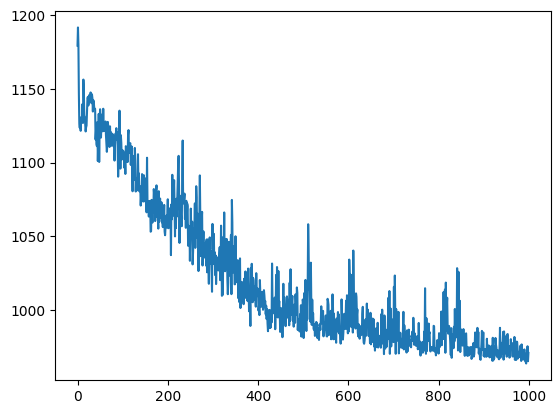

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 5.6643e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -2.7985e-05,  9.3002e-01],
         [ 5.5117e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.6699e-04,  6.6522e-03],
         [ 5.8389e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           2.5714e-03, -3.9352e-03],
         ...,
         [ 6.2915e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           2.8727e-01,  3.1798e-18],
         [ 6.9838e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -2.7935e-02, -3.2618e-19],
         [ 8.1697e-03,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           2.3050e-03,  2.6939e-20]],

        [[ 7.7566e-02,  0.0000e+00,  8.5452e-04,  ..., -2.1867e-14,
           1.9355e-05,  2.5281e-24],
         [ 5.3818e-02,  0.0000e+00,  6.9571e-03,  ..., -1.7810e-13,
           1.5764e-04,  2.0590e-23],
         [ 6.0492e-02,  0.0000e+00,  9.2210e-01,  ..., -4.3744e-12,
           3.8719e-03,  5.0573e-22],
         ...,
         [ 1.0673e-0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



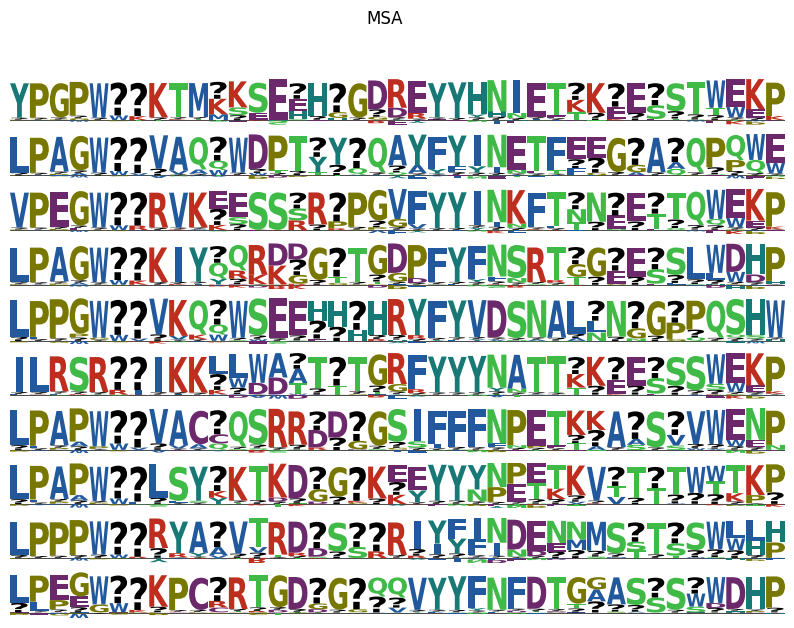

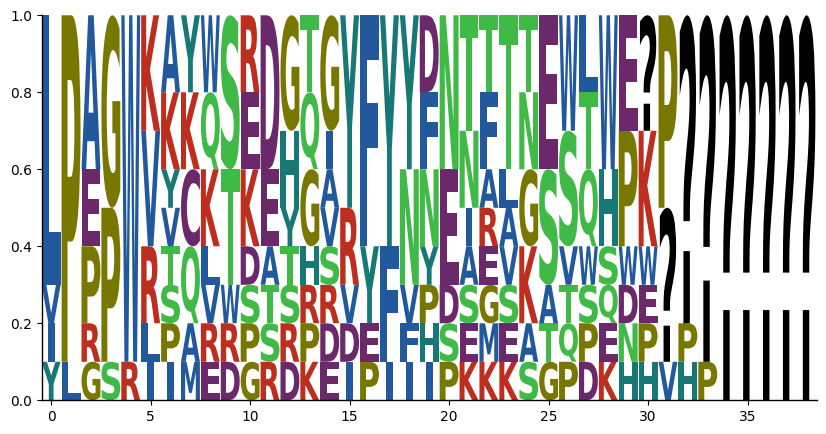

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



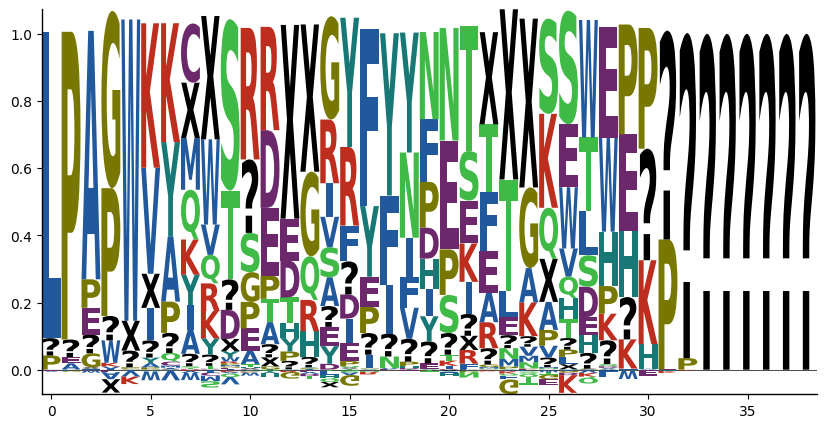

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



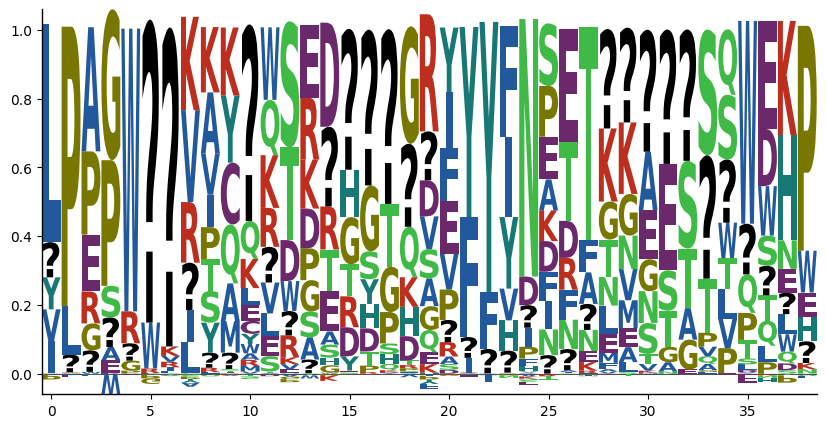

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



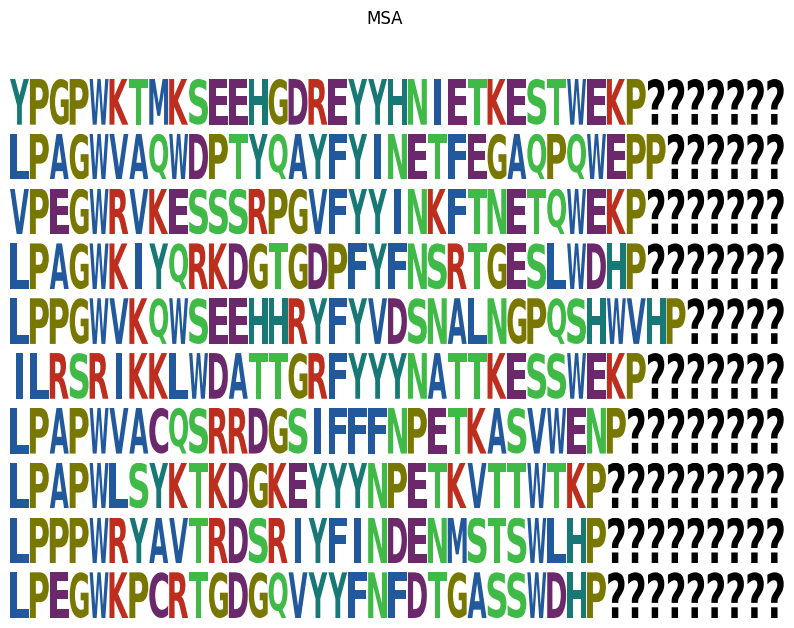

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


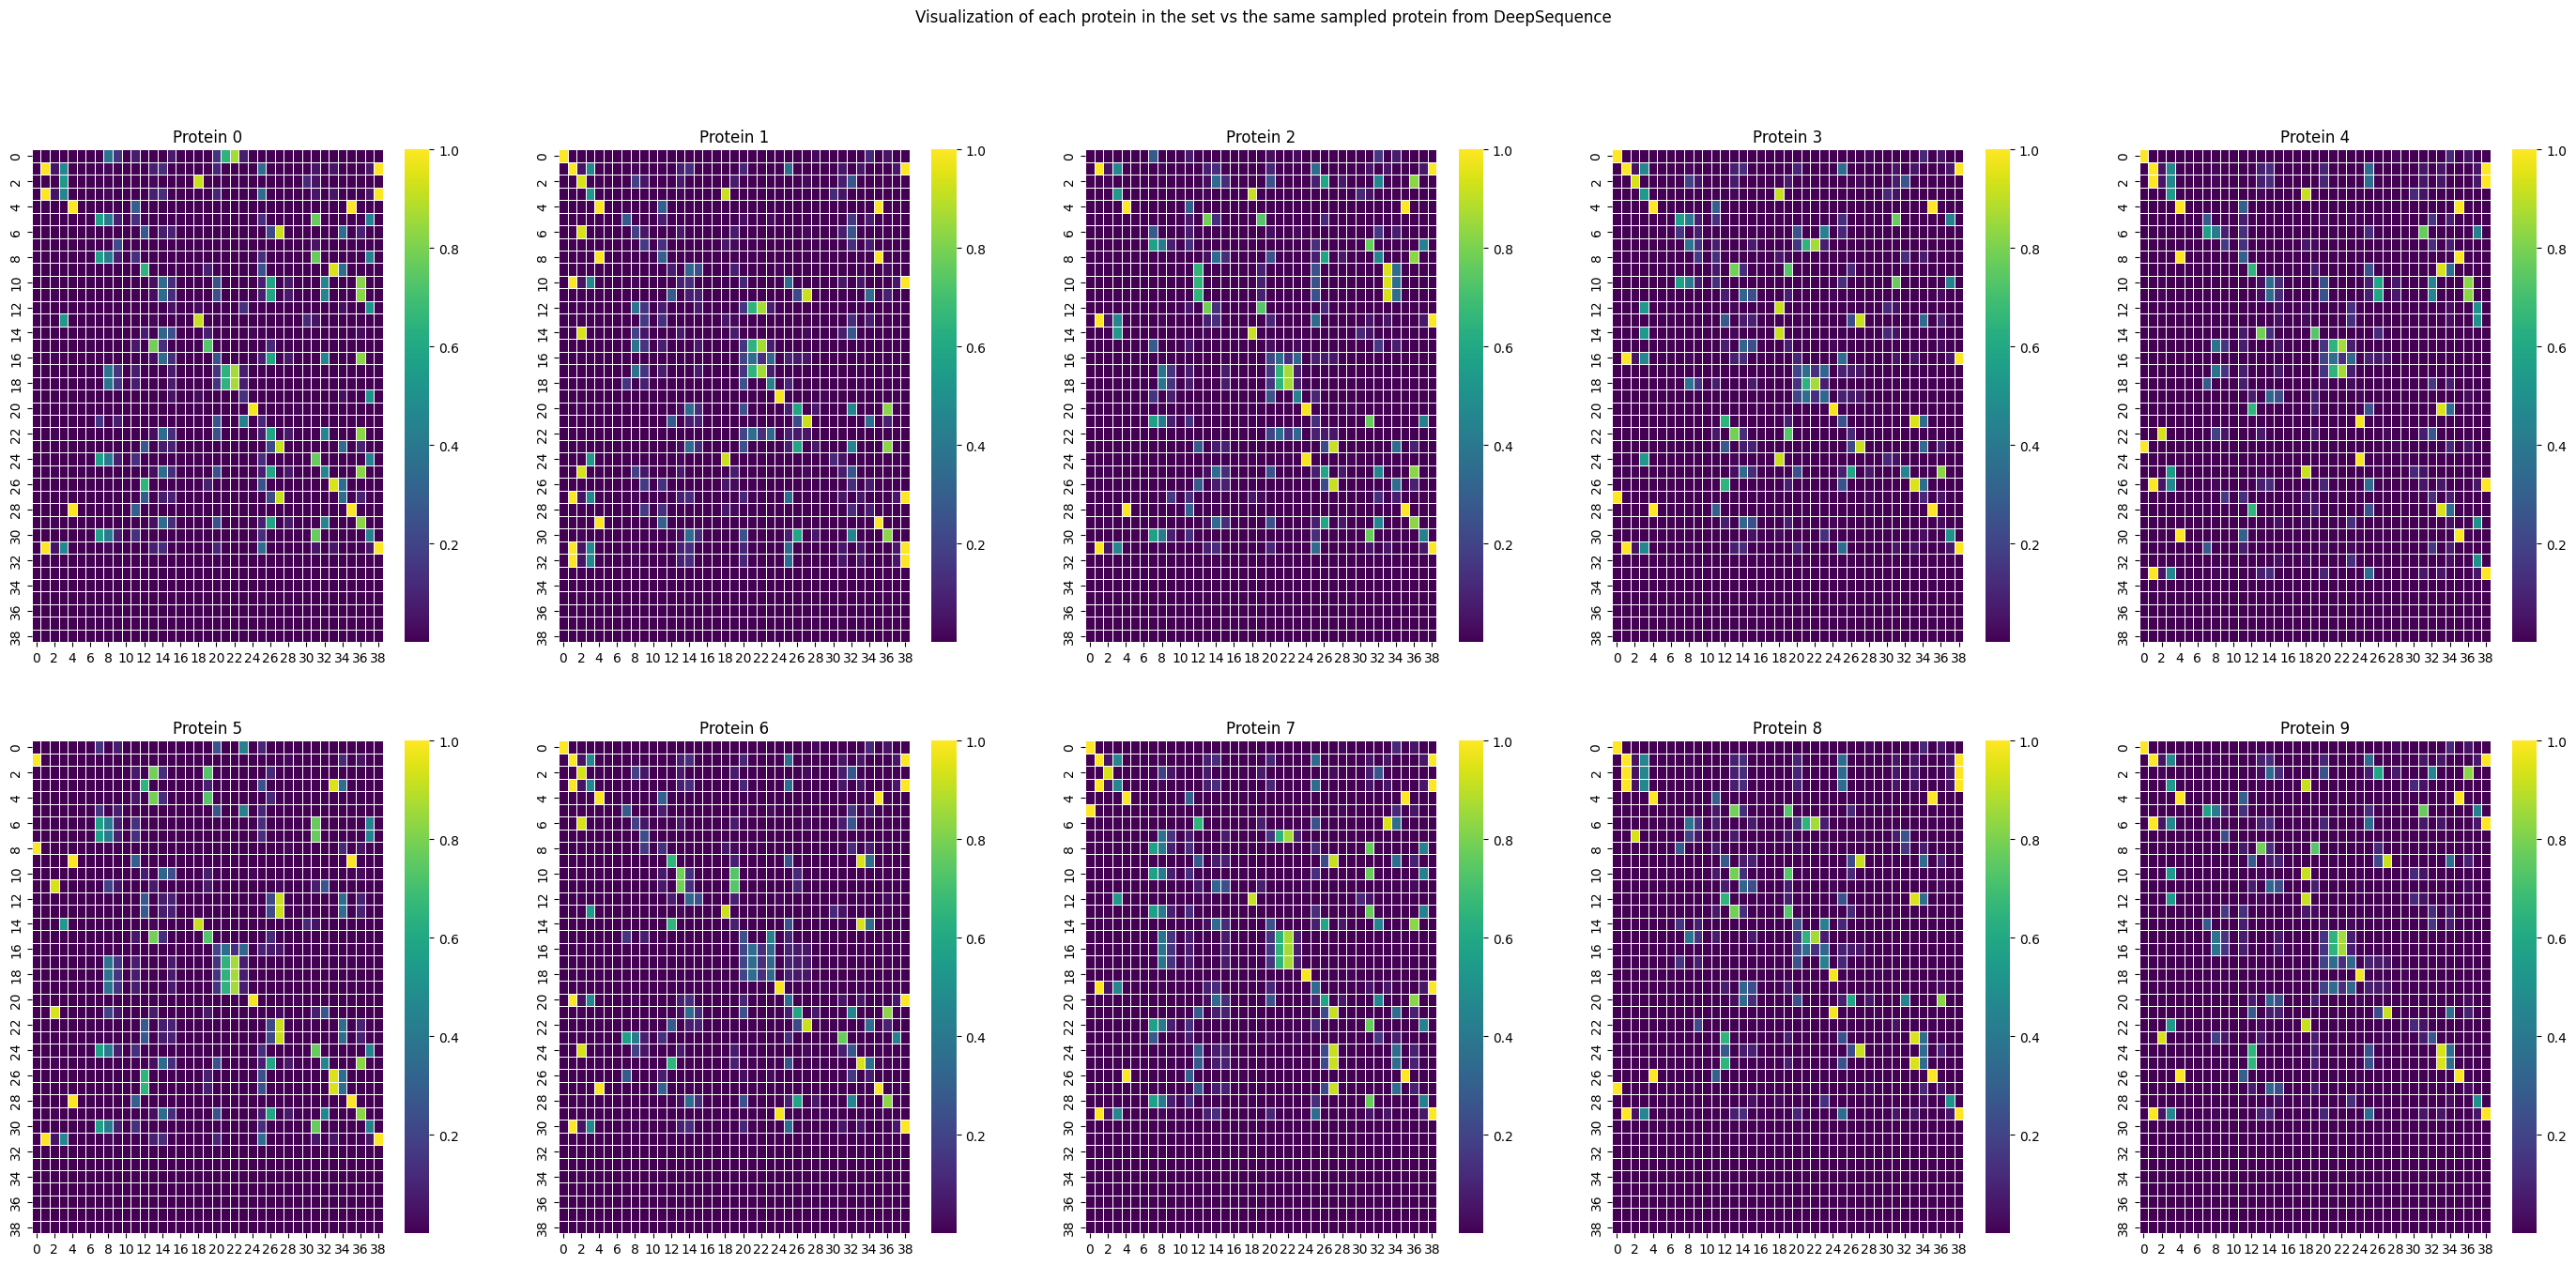

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):

    #import ipdb; ipdb.set_trace()
    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq.detach().cpu())
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.detach().cpu().numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq, dataset_msa.prot_space.detach())



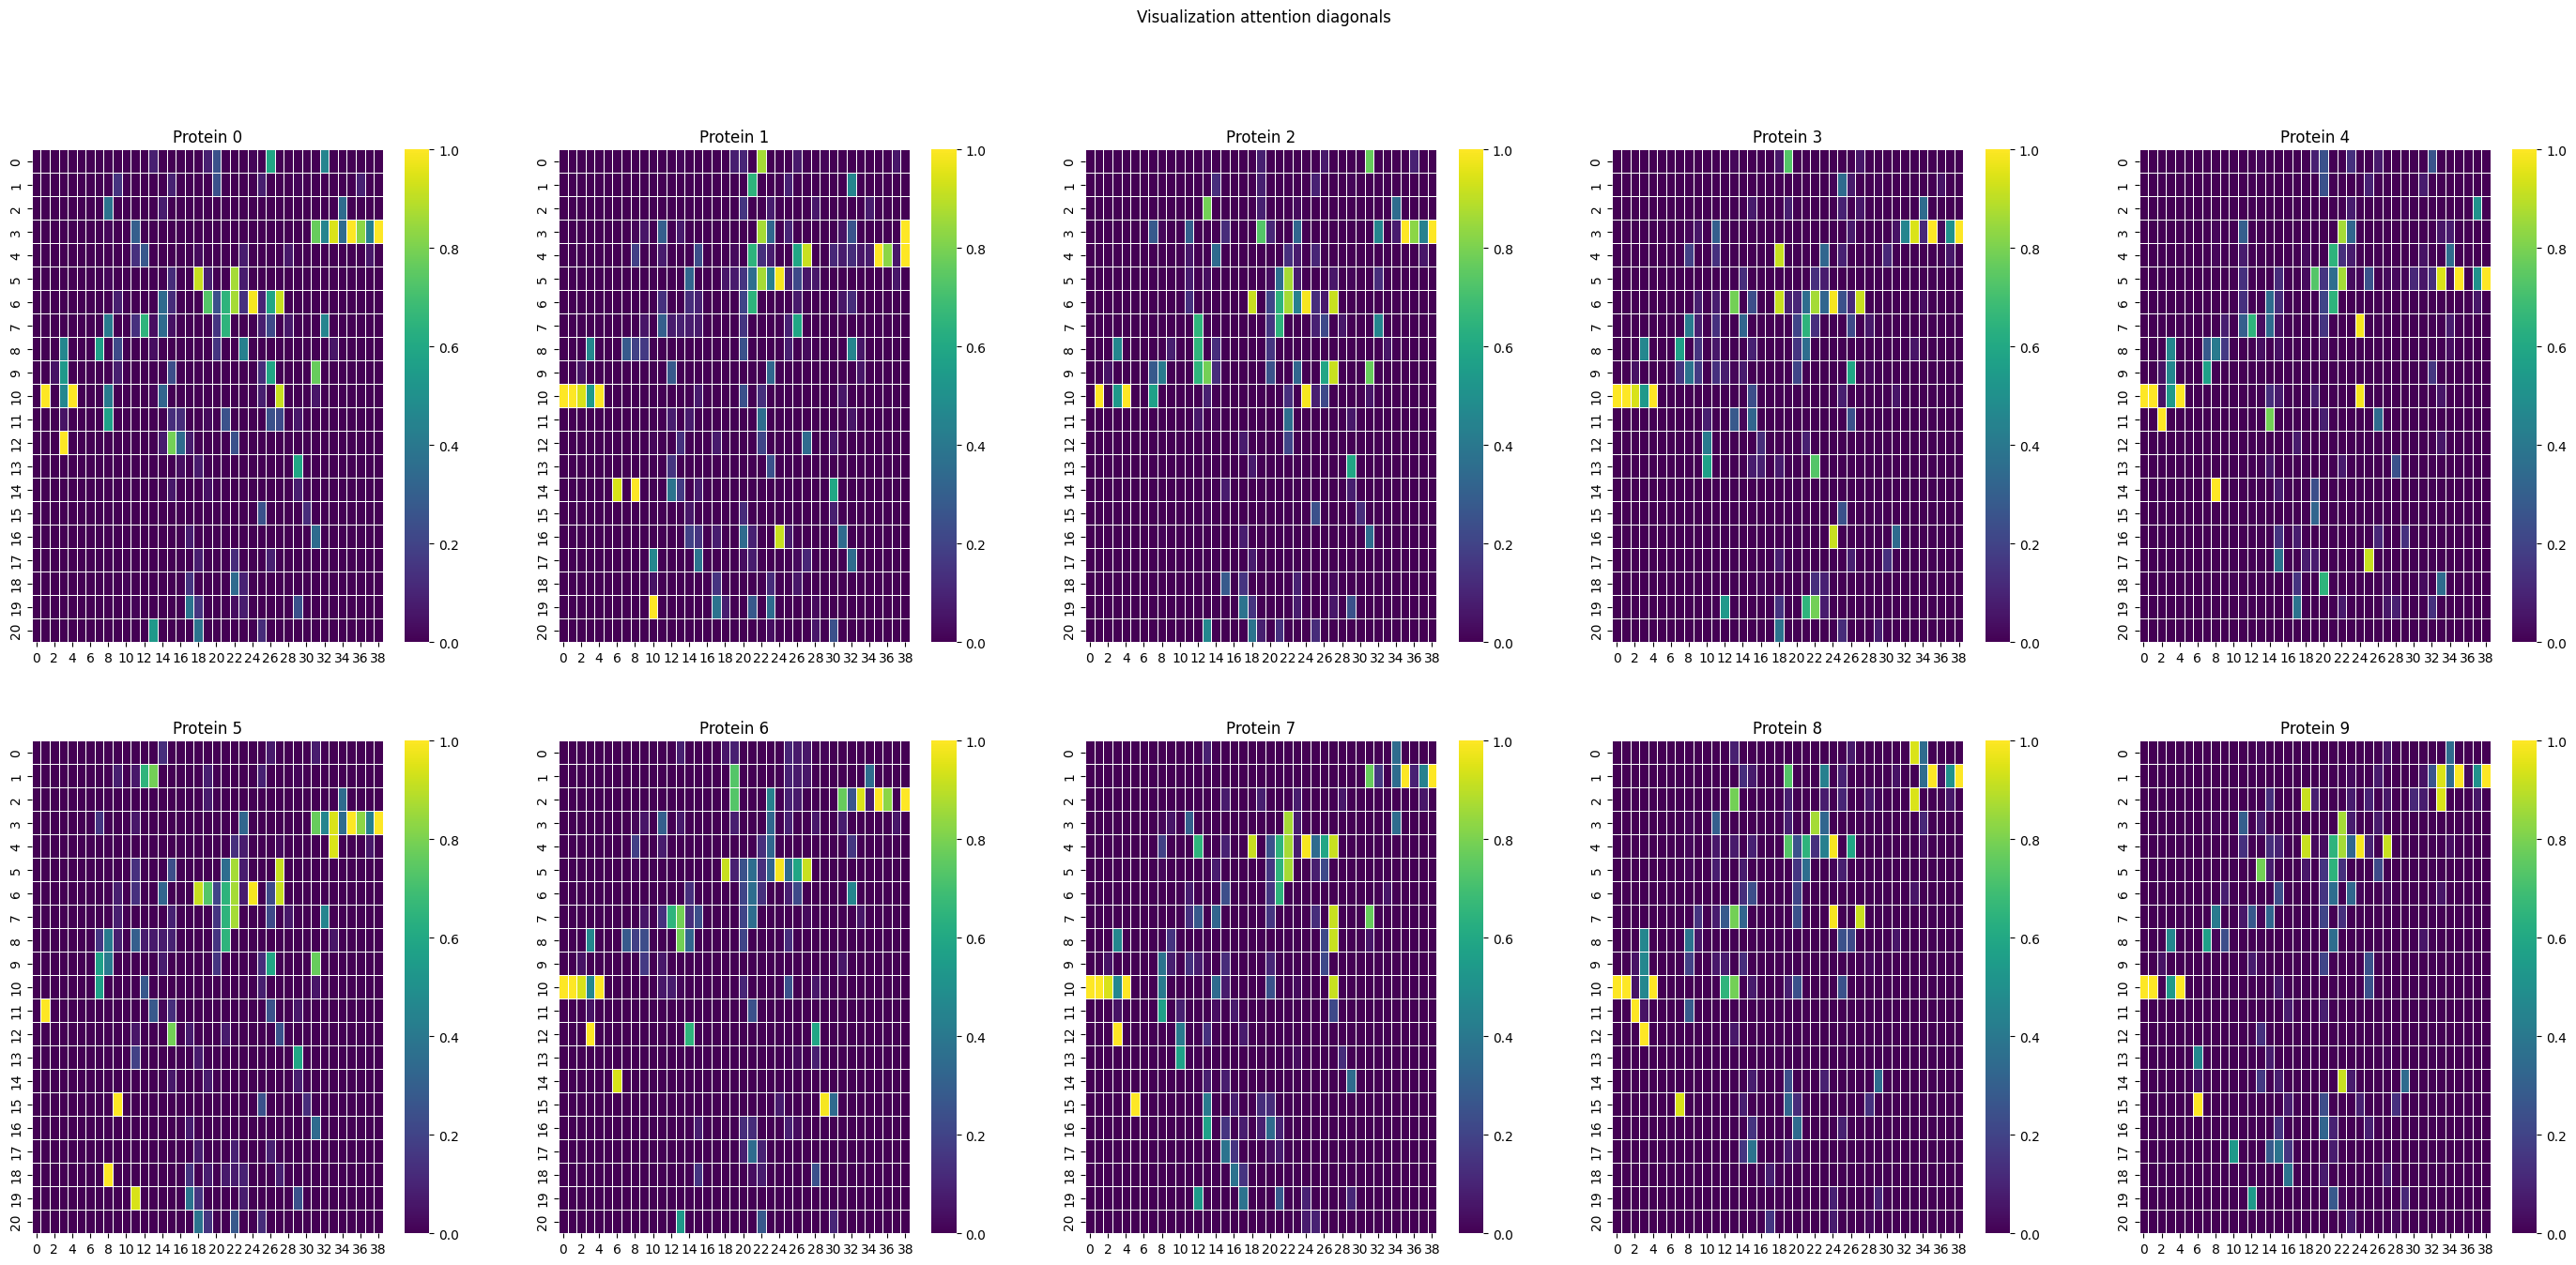

'\nMatrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])\nlist_attention = []\nget_diagonal_attention(Matrix, 2, -2, 2, list_attention)\n\nMatrix2 = Matrix.repeat(2,1,1)\nget_batch_diagonal_attention(Matrix2, 2, -2, 2)\n\nprint(list_attention)\n'

In [14]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

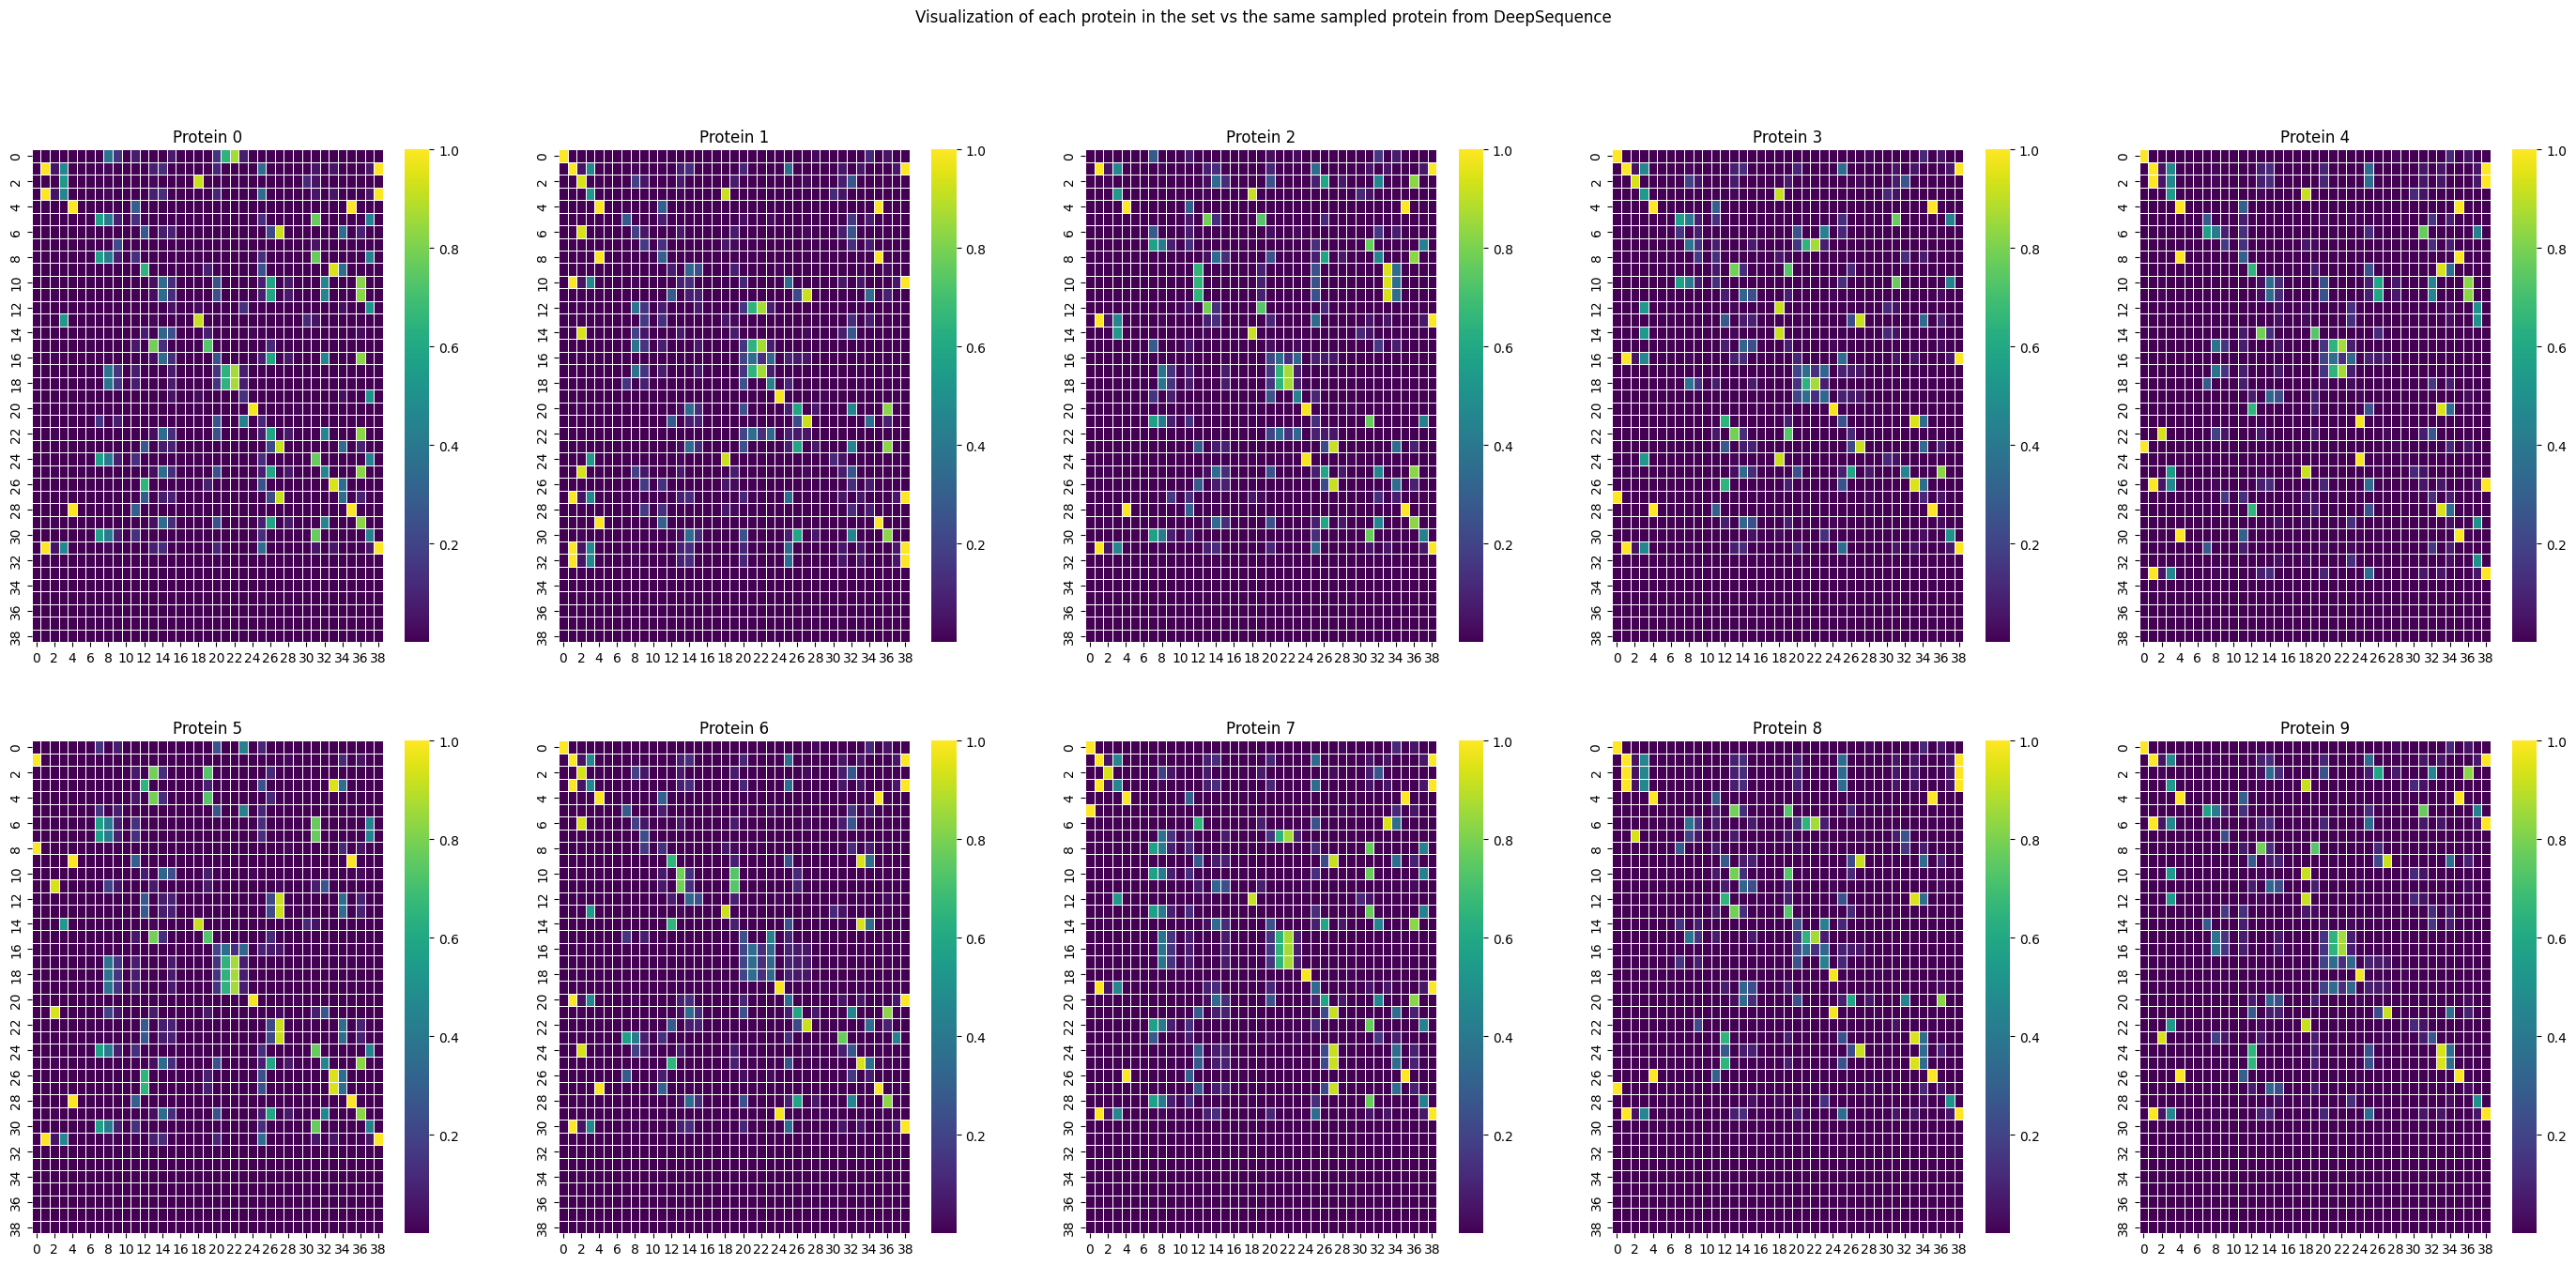

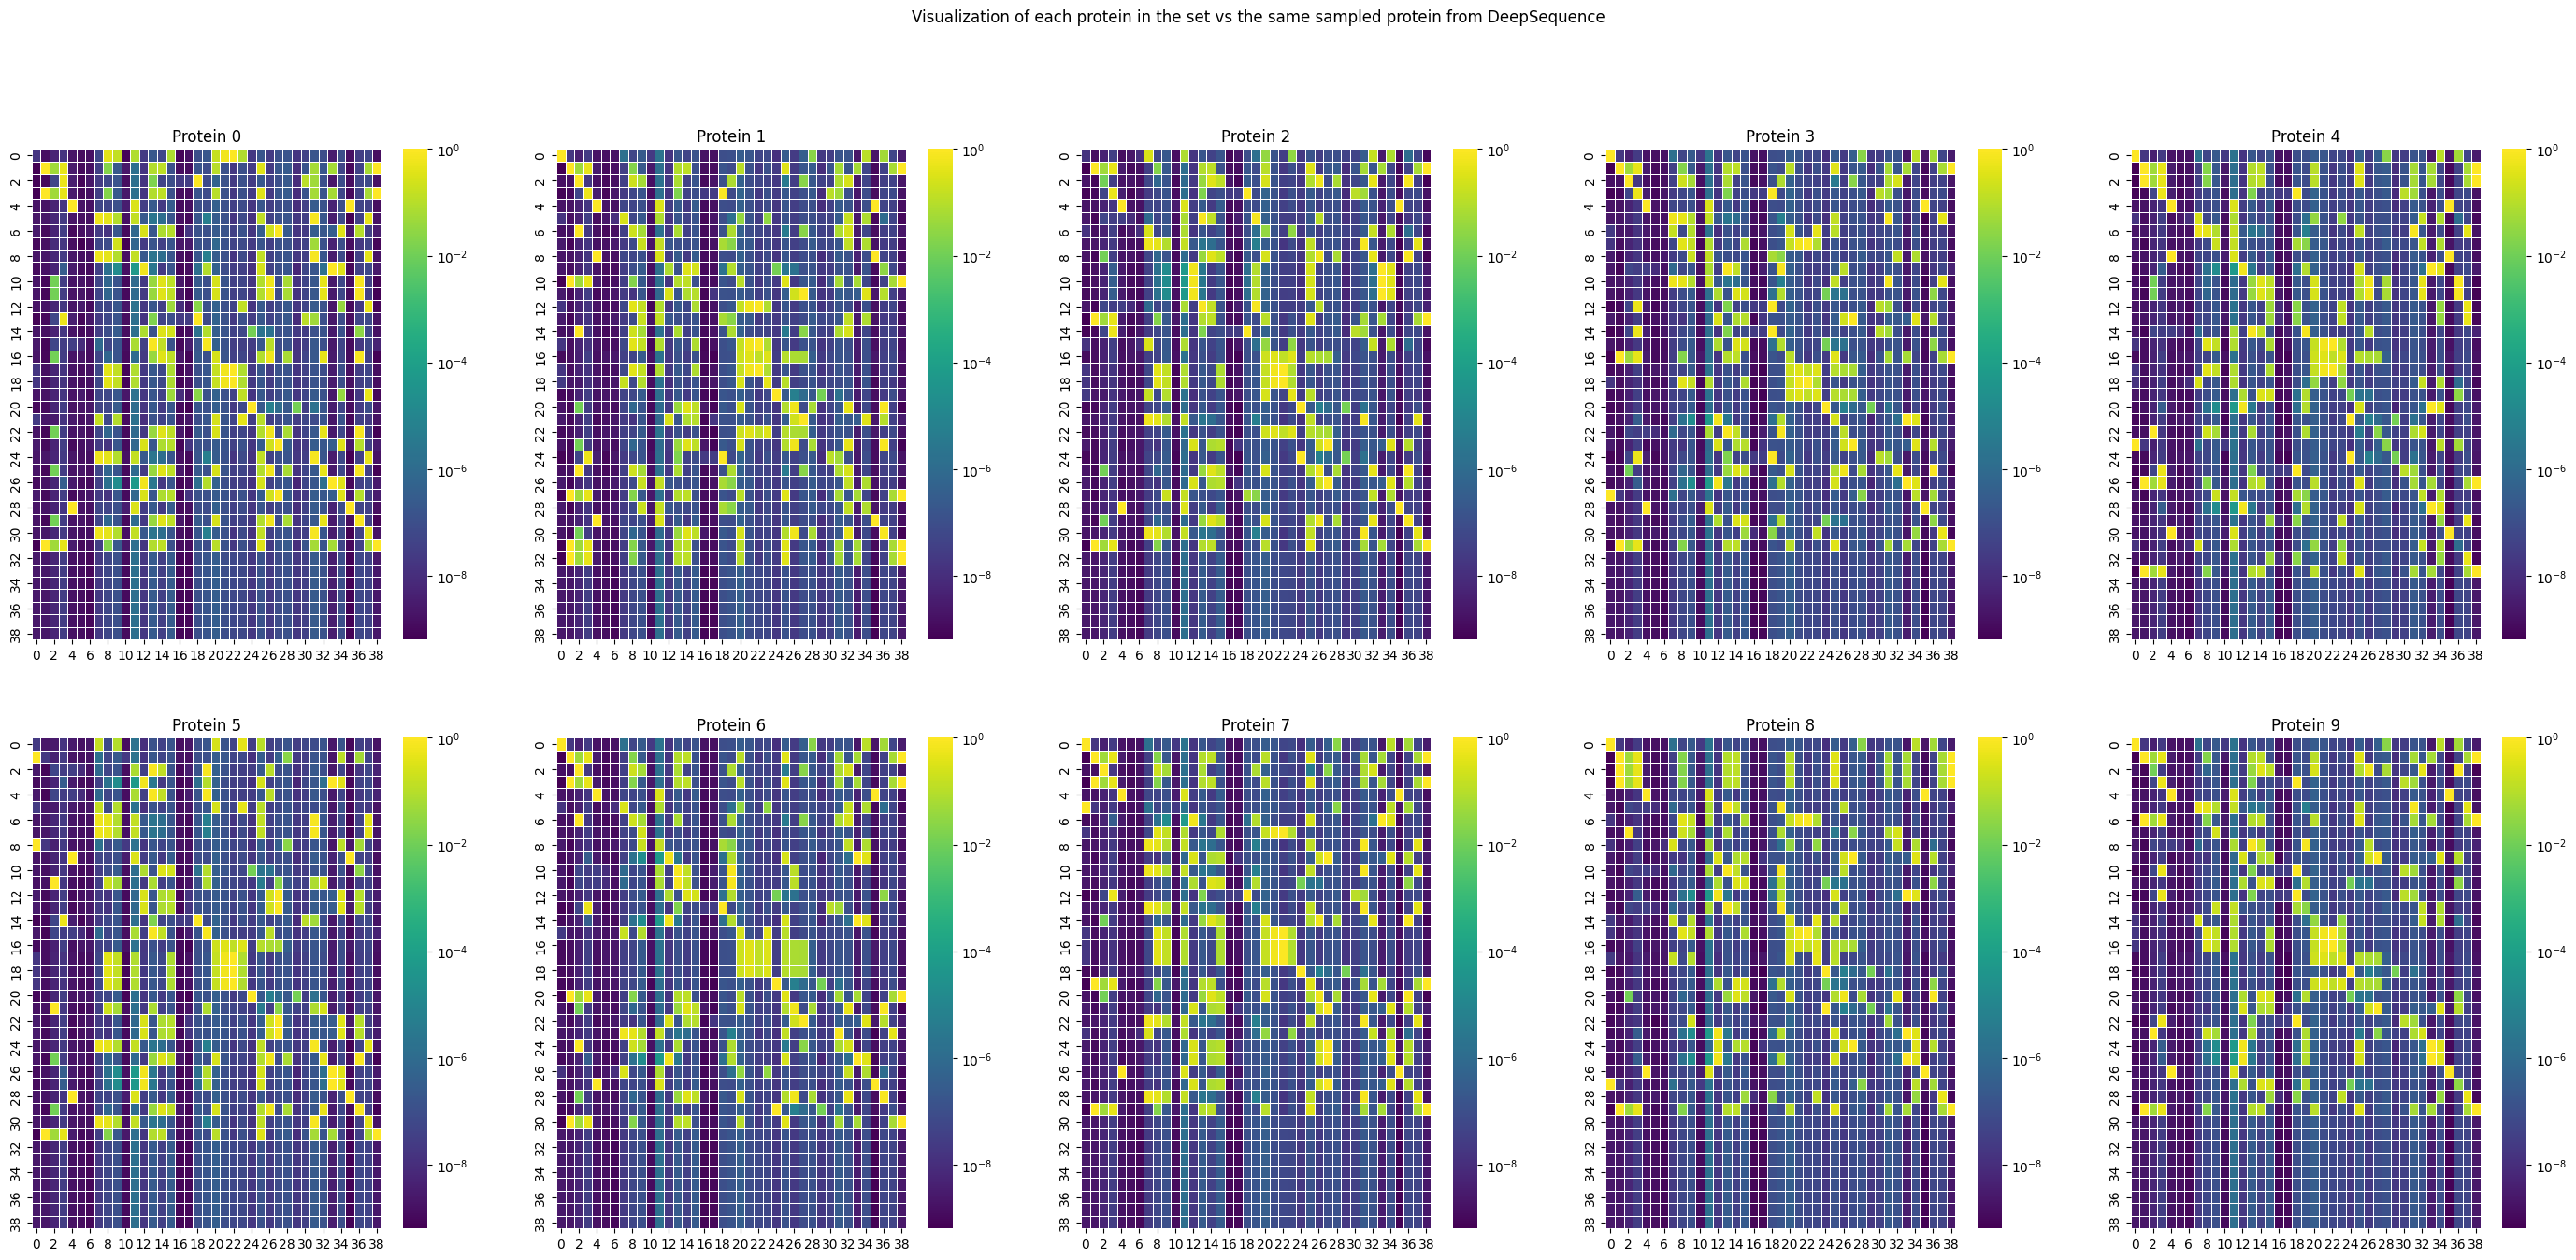

In [15]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()